# Covid-19 - Wealth Distribution

## Selected Euro Area Countries for Analysis

| Country       | Wealth Distribution Profile                                                                 | Key Features                                                                                     |
|---------------|---------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| Germany       | High wealth inequality, with a large gap between the richest and poorest households.         | Top 10% hold over 50% of net wealth; strong regional disparities (east vs. west).                |
| France        | Moderate inequality, but with significant wealth concentration at the top.                  | Top 10% hold around 45-50% of net wealth; high homeownership rates.                               |
| Slovenia      | Relatively lower inequality compared to Germany and France.                                 | More balanced distribution; top 10% hold closer to 35-40% of net wealth; smaller wealth gaps.   |

**Why these countries?**
- **Germany** is often cited for its high wealth inequality, influenced by historical, economic, and regional factors.
- **France** shows a more moderate but still pronounced concentration of wealth, with a strong middle class and high homeownership.
- **Slovenia** represents a case of lower inequality within the euro area, making it an interesting contrast for comparative analysis.

---
### Notebook Structure (Refactored)
1. Data loading & filtering
2. Reusable helpers (metric dictionaries, plotting, modeling, evaluation)
3. Exploratory wealth panels (per country)
4. Predictive modeling (2016–2019 → 2020–2025)
5. Prediction vs Actual comparisons
6. Error metrics & model diagnostics
7. COVID-19 data integration & merging
8. Joint COVID–wealth visualization & correlations
9. Summary insights & caveats

> The following cells now rely on helper functions to reduce duplication and improve clarity.

## 1. Import Libraries and Setup

In [1]:
# Import required libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set global plotting style for consistent visualizations
plt.style.use('seaborn-v0_8')

## 2. Configuration - Wealth Metrics Dictionary

Define the specific column names for each country's wealth distribution metrics in the dataset.

In [2]:
# Dictionary mapping country codes to their wealth metric column names in the dataset
# Each country has 5 key metrics: total assets, median wealth, mean wealth, net wealth, and Gini coefficient
WEALTH_METRICS = {
    'DE': {  # Germany
        'total_assets': 'Adjusted total assets of households (DWA.Q.DE.S14.A.LE.F_NNA._Z.EUR.S.N)',
        'median_wealth': 'Net wealth of households, median (DWA.Q.DE.S14.N.LE.NWA._Z.EUR_MD.S.N)',
        'mean_wealth': 'Net wealth of households, mean (DWA.Q.DE.S14.N.LE.NWA._Z.EUR_MN.S.N)',
        'net_wealth': 'Adjusted wealth (net) of households (DWA.Q.DE.S14.N.LE.NWA._Z.EUR.S.N)',
        'gini': 'Gini coefficient of households (DWA.Q.DE.S14._Z._Z.NWA._Z.GI.S.N)'
    },
    'FR': {  # France
        'total_assets': 'Adjusted total assets of households (DWA.Q.FR.S14.A.LE.F_NNA._Z.EUR.S.N)',
        'median_wealth': 'Net wealth of households, median (DWA.Q.FR.S14.N.LE.NWA._Z.EUR_MD.S.N)',
        'mean_wealth': 'Net wealth of households, mean (DWA.Q.FR.S14.N.LE.NWA._Z.EUR_MN.S.N)',
        'net_wealth': 'Adjusted wealth (net) of households (DWA.Q.FR.S14.N.LE.NWA._Z.EUR.S.N)',
        'gini': 'Gini coefficient of households (DWA.Q.FR.S14._Z._Z.NWA._Z.GI.S.N)'
    },
    'LT': {  # Slovenia (using LT code in dataset)
        'total_assets': 'Adjusted total assets of households (DWA.Q.LT.S14.A.LE.F_NNA._Z.EUR.S.N)',
        'median_wealth': 'Net wealth of households, median (DWA.Q.LT.S14.N.LE.NWA._Z.EUR_MD.S.N)',
        'mean_wealth': 'Net wealth of households, mean (DWA.Q.LT.S14.N.LE.NWA._Z.EUR_MN.S.N)',
        'net_wealth': 'Adjusted wealth (net) of households (DWA.Q.LT.S14.N.LE.NWA._Z.EUR.S.N)',
        'gini': 'Gini coefficient of households (DWA.Q.LT.S14._Z._Z.NWA._Z.GI.S.N)'
    }
}

# Human-readable country names for the codes
COUNTRY_NAMES = {'DE': 'Germany', 'FR': 'France', 'LT': 'Slovenia'}

## 3. Load and Filter Wealth Data

Load the distributional wealth accounts dataset and create training/testing splits.

In [3]:
# Load the wealth distribution dataset
DF_PATH = 'datasets/Distributional Wealth Accounts.csv'
df = pd.read_csv(DF_PATH)

# Convert DATE column to datetime for time-based filtering
df['DATE'] = pd.to_datetime(df['DATE'])

# Define time windows for analysis
# Training period: Pre-COVID era (2016-2019) - used to build prediction models
train_window = ('2016-01-01', '2019-12-31')
# Prediction period: COVID era (2020-2025) - used to compare predictions vs actual
predict_window = ('2020-01-01', '2025-12-31')

# Create boolean masks for filtering data
train_mask = (df['DATE'] >= train_window[0]) & (df['DATE'] <= train_window[1])
predict_mask = (df['DATE'] >= predict_window[0]) & (df['DATE'] <= predict_window[1])

# Split data into training and testing sets
df_filtered = df[train_mask].copy()  # For exploratory analysis
train_data = df[train_mask].copy()    # For model training
test_data = df[predict_mask].copy()   # For predictions and comparison

# Create numerical time axis (days since start) for regression modeling
# This converts dates to a numeric scale suitable for linear regression
train_data['days_since_start'] = (train_data['DATE'] - train_data['DATE'].min()).dt.days
test_data['days_since_start'] = (test_data['DATE'] - train_data['DATE'].min()).dt.days

## 4. Helper Functions - Wealth Visualization

Functions for plotting wealth distribution metrics over time.

In [4]:
def plot_country_wealth_panels(df_slice, country_code):
    """
    Create a 2x3 panel plot showing all wealth metrics for a specific country.
    
    Parameters:
    -----------
    df_slice : DataFrame
        Filtered DataFrame containing the data to plot
    country_code : str
        Country code ('DE', 'FR', or 'LT')
    
    Displays:
    ---------
    A figure with 6 subplots showing:
    - Total Assets, Median Wealth, Mean Wealth (top row)
    - Net Wealth, Gini Coefficient, empty panel (bottom row)
    """
    metrics = WEALTH_METRICS[country_code]
    name = COUNTRY_NAMES[country_code]
    
    # Create 2x3 subplot grid
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{name} - Wealth Distribution Metrics (2016-2019)', fontsize=16, fontweight='bold')

    # Plot 1: Total Assets
    axes[0, 0].plot(df_slice['DATE'], df_slice[metrics['total_assets']], color='#1f77b4', linewidth=2, marker='o')
    axes[0, 0].set_title('Adjusted Total Assets', fontweight='bold')
    axes[0, 0].set_ylabel('EUR (millions)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Plot 2: Median Wealth
    axes[0, 1].plot(df_slice['DATE'], df_slice[metrics['median_wealth']], color='#ff7f0e', linewidth=2, marker='o')
    axes[0, 1].set_title('Net Wealth - Median', fontweight='bold')
    axes[0, 1].set_ylabel('EUR')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Plot 3: Mean Wealth
    axes[0, 2].plot(df_slice['DATE'], df_slice[metrics['mean_wealth']], color='#2ca02c', linewidth=2, marker='o')
    axes[0, 2].set_title('Net Wealth - Mean', fontweight='bold')
    axes[0, 2].set_ylabel('EUR')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].tick_params(axis='x', rotation=45)

    # Plot 4: Net Wealth
    axes[1, 0].plot(df_slice['DATE'], df_slice[metrics['net_wealth']], color='#d62728', linewidth=2, marker='o')
    axes[1, 0].set_title('Adjusted Net Wealth', fontweight='bold')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('EUR (millions)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Plot 5: Gini Coefficient (inequality measure: higher = more inequality)
    axes[1, 1].plot(df_slice['DATE'], df_slice[metrics['gini']], color='#9467bd', linewidth=2, marker='o')
    axes[1, 1].set_title('Gini Coefficient', fontweight='bold')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Gini')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)

    # Hide the last subplot (not used)
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

## 5. Helper Functions - Prediction Models

Functions for training linear regression models and making predictions.

In [5]:
def train_predict_country(train_df, test_df, country_code, model_type='linear'):
    """
    Train regression models for all wealth metrics of a country and generate predictions.
    
    Supports multiple model types for comparison:
    - Linear: Simple trend extrapolation (baseline)
    - Polynomial: Captures non-linear patterns (degree 2)
    - Ridge: Regularized polynomial to prevent overfitting
    
    Parameters:
    -----------
    train_df : DataFrame
        Training data with 'days_since_start' column
    test_df : DataFrame
        Test data with 'days_since_start' column
    country_code : str
        Country code ('DE', 'FR', or 'LT')
    model_type : str, default='linear'
        Type of model: 'linear', 'polynomial', or 'ridge'
    
    Returns:
    --------
    dict
        Dictionary with metric keys and predicted values arrays
    """
    metrics = WEALTH_METRICS[country_code]
    results = {}
    
    # Train a separate model for each wealth metric
    for key, col in metrics.items():
        # Remove rows with missing values
        clean = train_df[['days_since_start', col]].dropna()
        if len(clean) < 3:  # Need at least 3 points for polynomial
            continue
        
        X_train = clean[['days_since_start']]
        y_train = clean[col]
        X_test = test_df[['days_since_start']]
        
        # Select and train model based on type
        if model_type == 'linear':
            # Simple linear regression: y = a*x + b
            model = LinearRegression()
            model.fit(X_train, y_train)
        elif model_type == 'polynomial':
            # Polynomial regression (degree 2): y = a*x^2 + b*x + c
            model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
            model.fit(X_train, y_train)
        elif model_type == 'ridge':
            # Ridge regression with polynomial features (regularized)
            model = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1.0))
            model.fit(X_train, y_train)
        else:
            raise ValueError(f"Unknown model_type: {model_type}")
        
        # Generate predictions for the test period
        preds = model.predict(X_test)
        results[key] = preds
    
    return results


def plot_prediction_vs_actual(test_df, preds_country, country_code, model_name='Linear'):
    """
    Plot predicted vs actual values for all wealth metrics to visualize COVID-19 impact.
    
    Parameters:
    -----------
    test_df : DataFrame
        Test data containing actual values
    preds_country : dict
        Dictionary of predictions from train_predict_country()
    country_code : str
        Country code ('DE', 'FR', or 'LT')
    model_name : str, default='Linear'
        Name of the model for the title
    
    Displays:
    ---------
    A 2x3 panel plot comparing predicted (dotted line) vs actual (solid line) values.
    Deviations indicate COVID-19 disruption to pre-pandemic trends.
    """
    name = COUNTRY_NAMES[country_code]
    metrics = WEALTH_METRICS[country_code]
    
    # Titles for each metric
    mapping_titles = {
        'total_assets': 'Adjusted Total Assets',
        'median_wealth': 'Net Wealth - Median',
        'mean_wealth': 'Net Wealth - Mean',
        'net_wealth': 'Adjusted Net Wealth',
        'gini': 'Gini Coefficient'
    }
    order = ['total_assets', 'median_wealth', 'mean_wealth', 'net_wealth', 'gini']
    
    # Create subplot grid
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle(f'{name} - {model_name} Prediction vs Actual (2020-2025)', 
                fontsize=16, fontweight='bold')
    
    # Plot each metric
    for idx, metric_key in enumerate(order):
        if metric_key not in preds_country:
            continue
        r, c = divmod(idx, 3)  # Calculate subplot position
        ax = axes[r, c]
        col = metrics[metric_key]
        
        # Plot actual values (solid line with circles)
        ax.plot(test_df['DATE'], test_df[col], 'o-', label='Actual', 
               linewidth=2, markersize=6, color='#1f77b4')
        # Plot predicted values (dashed line with squares)
        ax.plot(test_df['DATE'], preds_country[metric_key], 's--', label='Predicted', 
               linewidth=2, markersize=6, color='#ff7f0e')
        
        ax.set_title(mapping_titles[metric_key], fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Set appropriate y-axis label based on metric type
        if metric_key in ['total_assets', 'net_wealth']:
            ax.set_ylabel('EUR (millions)')
        elif metric_key in ['median_wealth', 'mean_wealth']:
            ax.set_ylabel('EUR')
        else:
            ax.set_ylabel('Gini')
        
        ax.legend()
    
    # Hide unused subplot
    axes[1, 2].axis('off')
    plt.tight_layout()
    plt.show()


def compare_models(train_df, test_df, country_code):
    """
    Compare multiple prediction models for a country and visualize results.
    
    Trains and evaluates Linear, Polynomial, and Ridge models to identify
    which approach best captures pre-pandemic trends.
    
    Parameters:
    -----------
    train_df : DataFrame
        Training data with 'days_since_start' column
    test_df : DataFrame
        Test data with 'days_since_start' column
    country_code : str
        Country code ('DE', 'FR', or 'LT')
    
    Returns:
    --------
    dict
        Dictionary with model names as keys and prediction dictionaries as values
    """
    models = {
        'Linear': train_predict_country(train_df, test_df, country_code, 'linear'),
        'Polynomial': train_predict_country(train_df, test_df, country_code, 'polynomial'),
        'Ridge': train_predict_country(train_df, test_df, country_code, 'ridge')
    }
    return models

## 6. Helper Functions - COVID-19 Data Processing

Functions for loading and aggregating COVID-19 case and death data.

In [6]:
# Path to COVID-19 dataset
COVID_PATH = 'datasets/EU Covid-19.csv'


def load_covid_data(path=COVID_PATH):
    """
    Load COVID-19 dataset and parse dates.
    
    Parameters:
    -----------
    path : str
        Path to COVID-19 CSV file
    
    Returns:
    --------
    DataFrame
        COVID-19 data with parsed date column
    """
    df_c = pd.read_csv(path)
    # Parse date from European format (DD/MM/YYYY)
    df_c['date'] = pd.to_datetime(df_c['dateRep'], format='%d/%m/%Y')
    return df_c


def aggregate_covid_quarterly(df_c, countries):
    """
    Aggregate daily COVID-19 data to quarterly totals for specific countries.
    
    This matches the quarterly frequency of wealth distribution data for proper merging.
    
    Parameters:
    -----------
    df_c : DataFrame
        Raw COVID-19 data with daily records
    countries : list
        List of country names to include
    
    Returns:
    --------
    DataFrame
        Quarterly aggregated data with cases/deaths per 100k population
    """
    # Filter for countries of interest
    filtered = df_c[df_c['countriesAndTerritories'].isin(countries)].copy()
    filtered = filtered.sort_values('date')
    
    # Extract year and quarter from date
    filtered['year'] = filtered['date'].dt.year
    filtered['quarter'] = filtered['date'].dt.quarter
    
    # Aggregate to quarterly level: sum cases and deaths, keep population
    quarterly = filtered.groupby(['countriesAndTerritories', 'year', 'quarter']).agg({
        'cases': 'sum',       # Total cases in the quarter
        'deaths': 'sum',      # Total deaths in the quarter
        'popData2020': 'first'  # Population (constant)
    }).reset_index()
    
    # Normalize by population to enable cross-country comparisons
    quarterly['cases_per_100k'] = (quarterly['cases'] / quarterly['popData2020']) * 100000
    quarterly['deaths_per_100k'] = (quarterly['deaths'] / quarterly['popData2020']) * 100000
    
    # Create DATE column matching wealth data format (end of quarter)
    quarterly['DATE'] = pd.to_datetime(
        quarterly['year'].astype(str) + '-' + (quarterly['quarter'] * 3).astype(str) + '-01'
    ) + pd.offsets.MonthEnd(0)
    
    return quarterly

## 7. Helper Functions - COVID-19 Visualization (Part 1)

Functions for visualizing COVID-19 data summaries and timelines.

In [7]:
def plot_covid_summary(quarterly):
    """
    Display summary information about the COVID-19 dataset.
    
    Parameters:
    -----------
    quarterly : DataFrame
        Quarterly aggregated COVID-19 data
    
    Displays:
    ---------
    A 2-panel figure showing:
    - Left: Date range and total records
    - Right: Sample of the first 10 records in a table
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('COVID-19 Data Summary', fontsize=16, fontweight='bold')
    
    # Left panel: Overview statistics
    date_info = f"Date Range:\n{quarterly['DATE'].min().strftime('%Y-%m-%d')}\nto\n{quarterly['DATE'].max().strftime('%Y-%m-%d')}"
    axes[0].text(0.5, 0.7, date_info, ha='center', va='center', fontsize=14,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    axes[0].text(0.5, 0.3, f"Total Records: {len(quarterly)}", ha='center', va='center', fontsize=14,
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].axis('off')
    axes[0].set_title('Data Overview', fontweight='bold')
    
    # Right panel: Sample data table
    sample = quarterly.head(10)
    table_data = [
        [r['countriesAndTerritories'][:8], r['DATE'].strftime('%Y-%m-%d'), 
         f"{r['cases']:,.0f}", f"{r['deaths']:,.0f}"]
        for _, r in sample.iterrows()
    ]
    axes[1].axis('tight')
    axes[1].axis('off')
    table = axes[1].table(cellText=table_data, 
                         colLabels=['Country', 'Date', 'Cases', 'Deaths'],
                         cellLoc='center', loc='center', colWidths=[0.25, 0.3, 0.25, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)
    
    # Format header row
    for i in range(4):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, len(table_data) + 1):
        for j in range(4):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#F2F2F2')
    
    axes[1].set_title('Sample Data (First 10 Records)', fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_covid_timelines(quarterly, countries):
    """
    Plot time series of COVID-19 cases and deaths for comparison across countries.
    
    Parameters:
    -----------
    quarterly : DataFrame
        Quarterly aggregated COVID-19 data
    countries : list
        List of country names to plot
    
    Displays:
    ---------
    Two stacked time series plots:
    - Top: Cases per 100k population over time
    - Bottom: Deaths per 100k population over time
    """
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    fig.suptitle('COVID-19 Cases and Deaths by Country (Quarterly)', fontsize=16, fontweight='bold')
    
    # Plot cases for each country
    for country in countries:
        data_c = quarterly[quarterly['countriesAndTerritories'] == country]
        axes[0].plot(data_c['DATE'], data_c['cases_per_100k'], 
                    marker='o', linewidth=2, markersize=5, label=country)
    
    axes[0].set_title('COVID-19 Cases per 100,000 Population', fontweight='bold', fontsize=12)
    axes[0].set_ylabel('Cases per 100k', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].axvline(x=pd.Timestamp('2020-03-31'), color='red', linestyle='--', 
                   alpha=0.5, label='Pandemic Start')
    
    # Plot deaths for each country
    for country in countries:
        data_c = quarterly[quarterly['countriesAndTerritories'] == country]
        axes[1].plot(data_c['DATE'], data_c['deaths_per_100k'], 
                    marker='o', linewidth=2, markersize=5, label=country)
    
    axes[1].set_title('COVID-19 Deaths per 100,000 Population', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Date', fontweight='bold')
    axes[1].set_ylabel('Deaths per 100k', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].axvline(x=pd.Timestamp('2020-03-31'), color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

## 8. Helper Functions - COVID-19 and Wealth Integration

Functions for merging COVID-19 data with wealth data and visualization.

In [8]:
def merge_covid_wealth(df_wealth, quarterly, country_name, code):
    """
    Merge COVID-19 and wealth distribution data for a specific country.
    
    This enables analysis of correlations between pandemic severity and wealth changes.
    
    Parameters:
    -----------
    df_wealth : DataFrame
        Full wealth distribution dataset
    quarterly : DataFrame
        Quarterly COVID-19 data
    country_name : str
        Full country name for COVID data (e.g., 'Germany')
    code : str
        Country code for wealth data (e.g., 'DE')
    
    Returns:
    --------
    DataFrame
        Merged dataset with both wealth metrics and COVID-19 severity indicators
    """
    # Define metric column names
    metrics = {
        'gini': f'Gini coefficient of households (DWA.Q.{code}.S14._Z._Z.NWA._Z.GI.S.N)',
        'median_wealth': f'Net wealth of households, median (DWA.Q.{code}.S14.N.LE.NWA._Z.EUR_MD.S.N)',
        'mean_wealth': f'Net wealth of households, mean (DWA.Q.{code}.S14.N.LE.NWA._Z.EUR_MN.S.N)'
    }
    
    # Extract wealth data from 2020 onwards (COVID period)
    wealth = df_wealth[df_wealth['DATE'] >= '2020-01-01'][
        ['DATE', metrics['gini'], metrics['median_wealth'], metrics['mean_wealth']]
    ].copy()
    wealth.columns = ['DATE', 'gini', 'median_wealth', 'mean_wealth']
    
    # Extract COVID data for specific country
    covid_part = quarterly[quarterly['countriesAndTerritories'] == country_name][
        ['DATE', 'cases_per_100k', 'deaths_per_100k']
    ].copy()
    
    # Merge on DATE (left join keeps all wealth data points)
    merged = pd.merge(wealth, covid_part, on='DATE', how='left')
    merged['country'] = country_name
    
    return merged


def plot_merge_summary(merged_dict):
    """
    Display summary table of merged COVID-wealth datasets.
    
    Parameters:
    -----------
    merged_dict : dict
        Dictionary of {country_name: merged_dataframe}
    
    Displays:
    ---------
    Table showing rows, columns, and complete records for each country
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')
    
    # Create summary data
    summary_data = []
    for name, df_m in merged_dict.items():
        summary_data.append([
            name, 
            df_m.shape[0],  # Total rows
            df_m.shape[1],  # Total columns
            df_m.dropna().shape[0]  # Complete records (no missing values)
        ])
    
    table = ax.table(cellText=summary_data, 
                    colLabels=['Country', 'Total Rows', 'Total Columns', 'Complete Records'],
                    cellLoc='center', loc='center', colWidths=[0.3, 0.25, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2.5)
    
    # Format header
    for i in range(4):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color rows by country
    colors = ['#FFE699', '#C6E0B4', '#B4C7E7']
    for i in range(1, len(summary_data) + 1):
        for j in range(4):
            table[(i, j)].set_facecolor(colors[i - 1])
    
    plt.title('COVID-19 and Wealth Data Merge Summary', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

## 9. Helper Functions - Dual-Axis COVID-Wealth Plots

Function for plotting wealth metrics alongside COVID-19 severity on dual y-axes.

In [9]:
def plot_covid_wealth_dual_axis(merged, country_name):
    """
    Create dual-axis plots showing wealth metrics and COVID-19 severity together.
    
    This visualization helps identify temporal relationships between pandemic waves
    and changes in wealth distribution.
    
    Parameters:
    -----------
    merged : DataFrame
        Merged COVID-wealth data for a country
    country_name : str
        Name of the country for the title
    
    Displays:
    ---------
    Three stacked dual-axis plots:
    - Gini coefficient vs COVID-19 deaths
    - Median wealth vs COVID-19 cases
    - Mean wealth vs COVID-19 cases
    """
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    fig.suptitle(f'{country_name} - COVID-19 Impact on Wealth Distribution', 
                fontsize=16, fontweight='bold')
    
    # Plot 1: Gini vs Deaths
    ax1, ax2 = axes[0], axes[0].twinx()
    ax1.plot(merged['DATE'], merged['gini'], 'o-', color='#9467bd', 
            linewidth=2, markersize=6, label='Gini')
    ax2.plot(merged['DATE'], merged['deaths_per_100k'], 's--', color='#d62728', 
            linewidth=2, markersize=5, alpha=0.7, label='Deaths/100k')
    ax1.set_ylabel('Gini', fontweight='bold', color='#9467bd')
    ax2.set_ylabel('Deaths/100k', fontweight='bold', color='#d62728')
    ax1.set_title('Wealth Inequality vs COVID-19 Deaths', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    lines = ax1.lines + ax2.lines
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')
    
    # Plot 2: Median Wealth vs Cases
    ax3, ax4 = axes[1], axes[1].twinx()
    ax3.plot(merged['DATE'], merged['median_wealth'], 'o-', color='#ff7f0e', 
            linewidth=2, markersize=6, label='Median Wealth')
    ax4.plot(merged['DATE'], merged['cases_per_100k'], 's--', color='#1f77b4', 
            linewidth=2, markersize=5, alpha=0.7, label='Cases/100k')
    ax3.set_ylabel('Median Wealth (EUR)', fontweight='bold', color='#ff7f0e')
    ax4.set_ylabel('Cases/100k', fontweight='bold', color='#1f77b4')
    ax3.set_title('Median Wealth vs COVID-19 Cases', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    lines = ax3.lines + ax4.lines
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc='upper left')
    
    # Plot 3: Mean Wealth vs Cases
    ax5, ax6 = axes[2], axes[2].twinx()
    ax5.plot(merged['DATE'], merged['mean_wealth'], 'o-', color='#2ca02c', 
            linewidth=2, markersize=6, label='Mean Wealth')
    ax6.plot(merged['DATE'], merged['cases_per_100k'], 's--', color='#1f77b4', 
            linewidth=2, markersize=5, alpha=0.7, label='Cases/100k')
    ax5.set_ylabel('Mean Wealth (EUR)', fontweight='bold', color='#2ca02c')
    ax6.set_ylabel('Cases/100k', fontweight='bold', color='#1f77b4')
    ax5.set_title('Mean Wealth vs COVID-19 Cases', fontweight='bold')
    ax5.set_xlabel('Date', fontweight='bold')
    ax5.grid(True, alpha=0.3)
    lines = ax5.lines + ax6.lines
    labels = [l.get_label() for l in lines]
    ax5.legend(lines, labels, loc='upper left')
    
    plt.tight_layout()
    plt.show()

## 10. Helper Functions - Correlation Analysis

Functions for computing and visualizing correlations between COVID-19 and wealth metrics.

In [10]:
def compute_correlations(merged):
    """
    Compute correlation coefficients between COVID-19 severity and wealth metrics.
    
    Correlation values range from -1 to +1:
    - Positive: Variables increase together
    - Negative: One increases when other decreases
    - Zero: No linear relationship
    
    Parameters:
    -----------
    merged : DataFrame
        Merged COVID-wealth data
    
    Returns:
    --------
    dict : Correlation values for key relationships
    """
    correlations = {
        'Gini vs Cases': merged['gini'].corr(merged['cases_per_100k']),
        'Gini vs Deaths': merged['gini'].corr(merged['deaths_per_100k']),
        'Median Wealth vs Cases': merged['median_wealth'].corr(merged['cases_per_100k']),
        'Median Wealth vs Deaths': merged['median_wealth'].corr(merged['deaths_per_100k']),
        'Mean Wealth vs Cases': merged['mean_wealth'].corr(merged['cases_per_100k']),
        'Mean Wealth vs Deaths': merged['mean_wealth'].corr(merged['deaths_per_100k'])
    }
    return correlations


def plot_correlation_heatmap(merged_dict):
    """
    Create correlation heatmap visualizations for all countries.
    
    Visualizes the strength and direction of linear relationships between
    wealth metrics (Gini, median/mean wealth) and COVID-19 severity (cases/deaths).
    
    Parameters:
    -----------
    merged_dict : dict
        Dictionary with country names as keys and merged DataFrames as values
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('COVID-19 vs Wealth Metrics: Correlation Analysis', 
                fontsize=16, fontweight='bold')
    
    for ax, (name, merged) in zip(axes.flatten(), merged_dict.items()):
        # Select numeric columns for correlation
        cols = ['gini', 'median_wealth', 'mean_wealth', 'cases_per_100k', 'deaths_per_100k']
        corr_matrix = merged[cols].corr()
        
        # Create heatmap
        im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
        
        # Set tick labels
        ax.set_xticks(np.arange(len(corr_matrix.columns)))
        ax.set_yticks(np.arange(len(corr_matrix.columns)))
        ax.set_xticklabels(['Gini', 'Median\nWealth', 'Mean\nWealth', 
                           'Cases\nper 100k', 'Deaths\nper 100k'], fontsize=9)
        ax.set_yticklabels(['Gini', 'Median Wealth', 'Mean Wealth', 
                           'Cases per 100k', 'Deaths per 100k'], fontsize=9)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        
        # Add correlation values as text
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix)):
                ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", 
                       ha='center', va='center', color='black', fontsize=9)
        
        ax.set_title(name, fontweight='bold', fontsize=12)
    
    # Add colorbar
    fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.1, 
                shrink=0.8, label='Correlation Coefficient')
    plt.tight_layout()
    plt.show()

## Germany - Wealth Distribution Metrics

Visualization of key wealth indicators for German households over time.

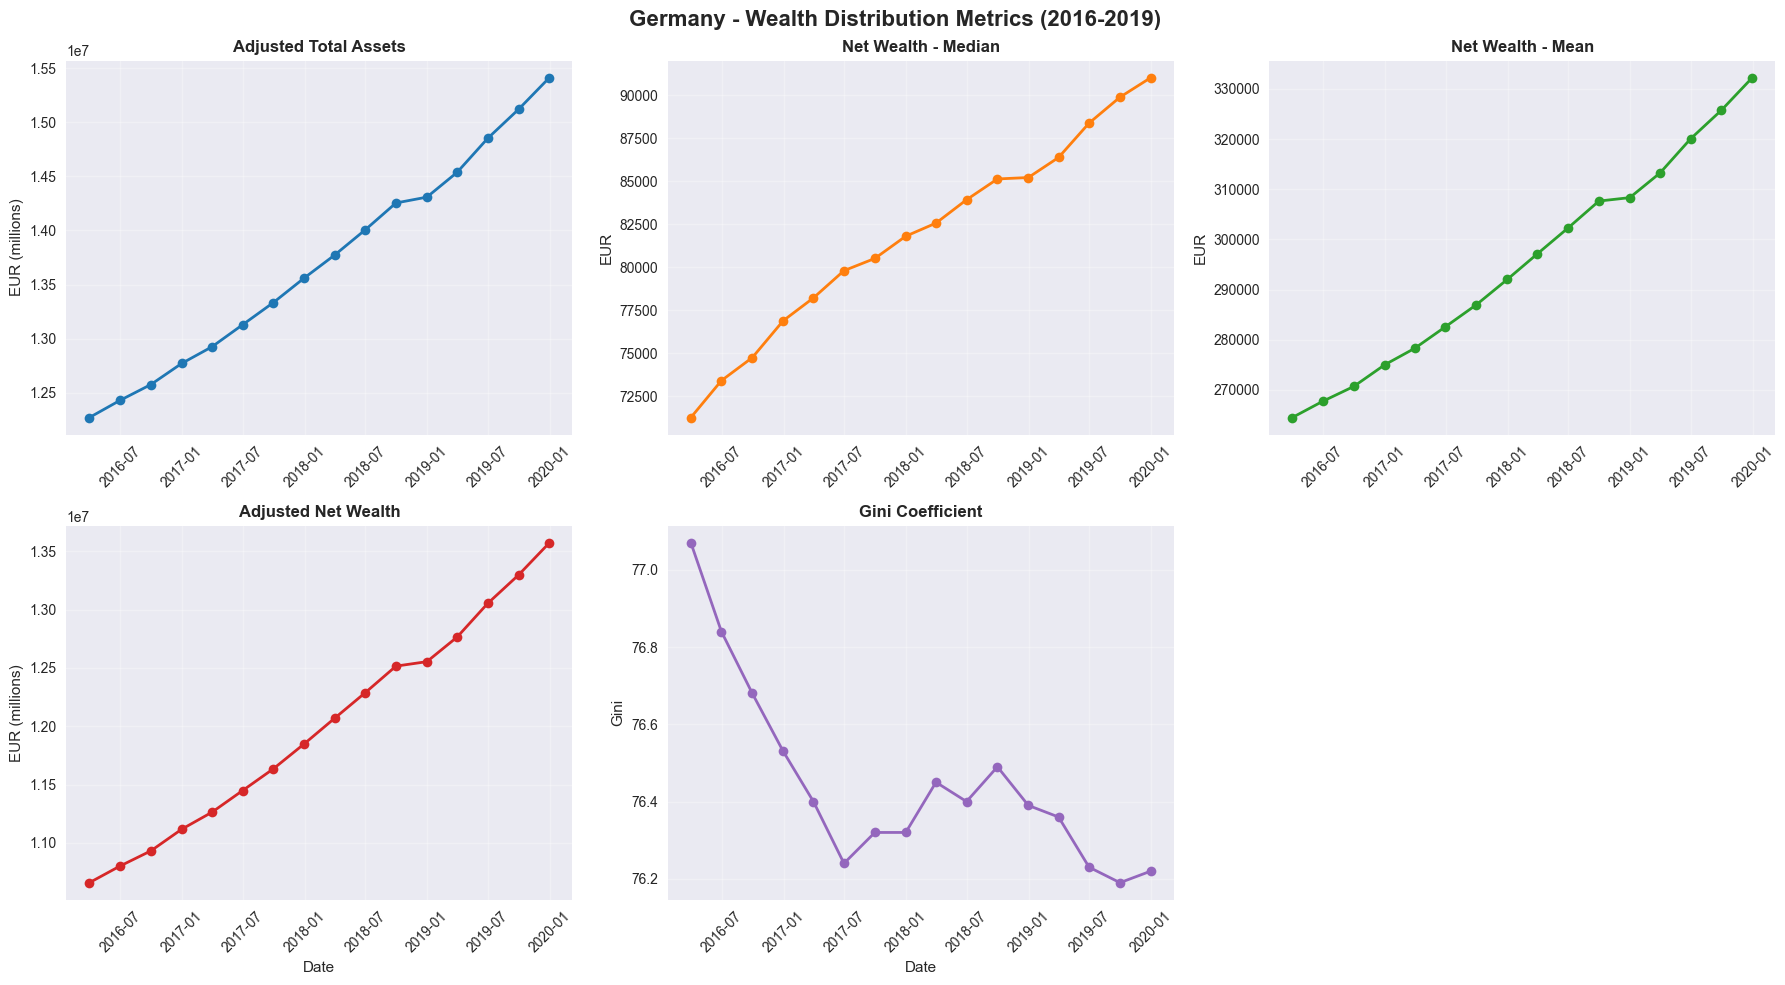

In [11]:
# Display wealth distribution metrics for Germany (2016-2019)
# Shows pre-pandemic trends across 5 key wealth indicators
plot_country_wealth_panels(df_filtered, 'DE')

## France - Wealth Distribution Metrics

Visualization of key wealth indicators for French households over time.

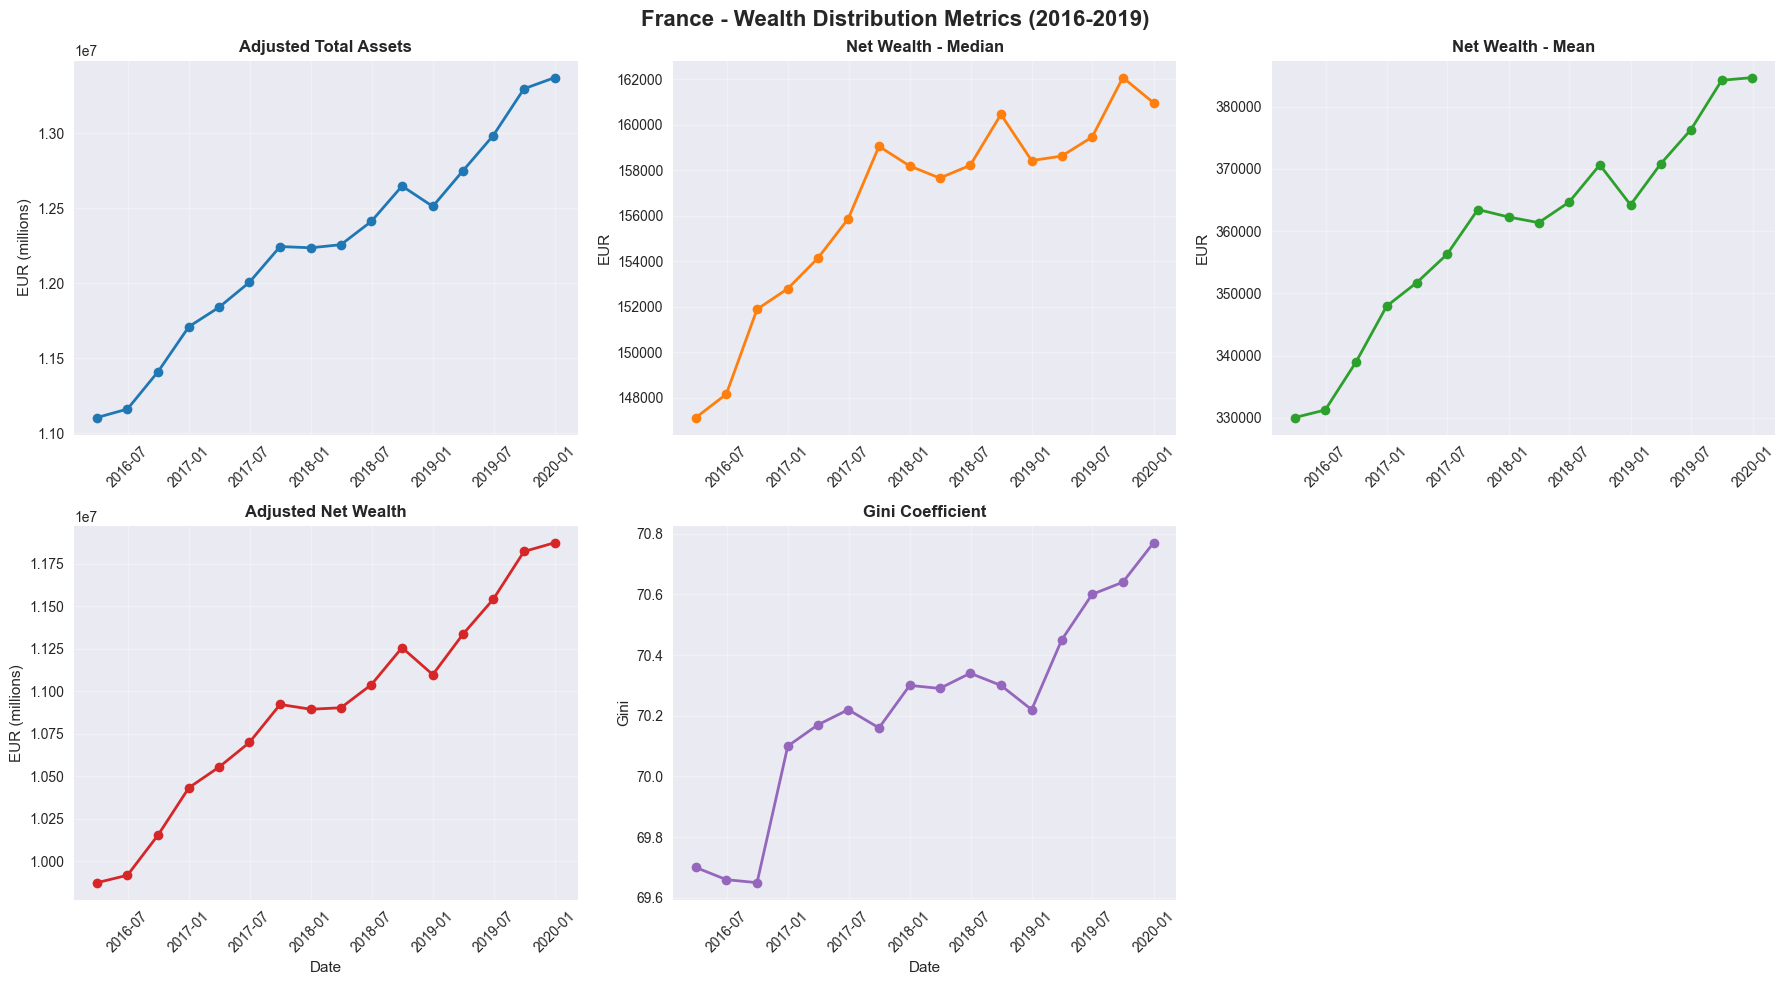

In [12]:
# Display wealth distribution metrics for France (2016-2019)
# Shows pre-pandemic trends across 5 key wealth indicators
plot_country_wealth_panels(df_filtered, 'FR')

## Slovenia - Wealth Distribution Metrics

Visualization of key wealth indicators for Slovenian households over time.

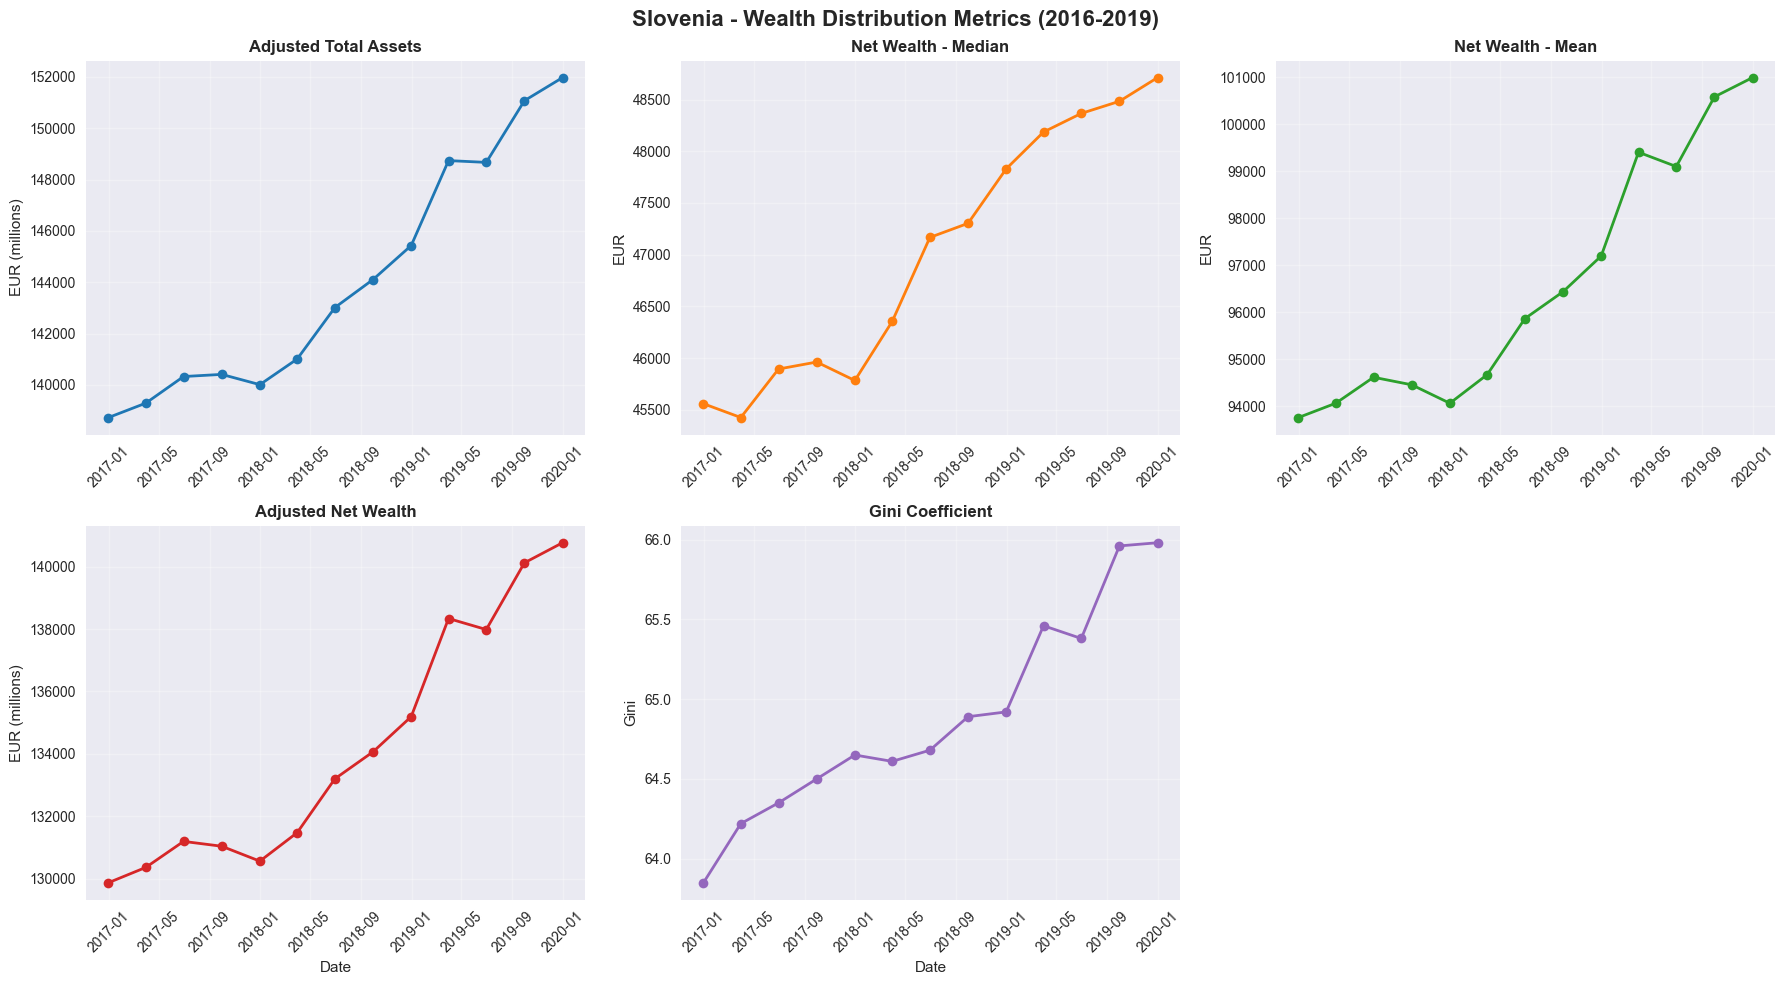

In [13]:
# Display wealth distribution metrics for Slovenia (2016-2019)
# Shows pre-pandemic trends across 5 key wealth indicators
plot_country_wealth_panels(df_filtered, 'LT')

## Predictive Analysis: 2020-2025

Using linear regression on 2016-2019 data to predict 2020-2025 values and compare with actual outcomes.

## Enhanced Predictive Analysis with Multiple Models

Compare Linear, Polynomial, and Ridge regression models to evaluate which best captures pre-pandemic trends.

In [14]:
# ===== Train Multiple Model Types for Comparison =====
# Compare Linear, Polynomial (degree 2), and Ridge regression approaches
# This helps identify which model best captures pre-pandemic patterns

# Dictionary to store all model predictions
enhanced_predictions = {}

for code in ['DE', 'FR', 'LT']:
    enhanced_predictions[code] = compare_models(train_data, test_data, code)

### Model Comparison - Germany (All Three Models)

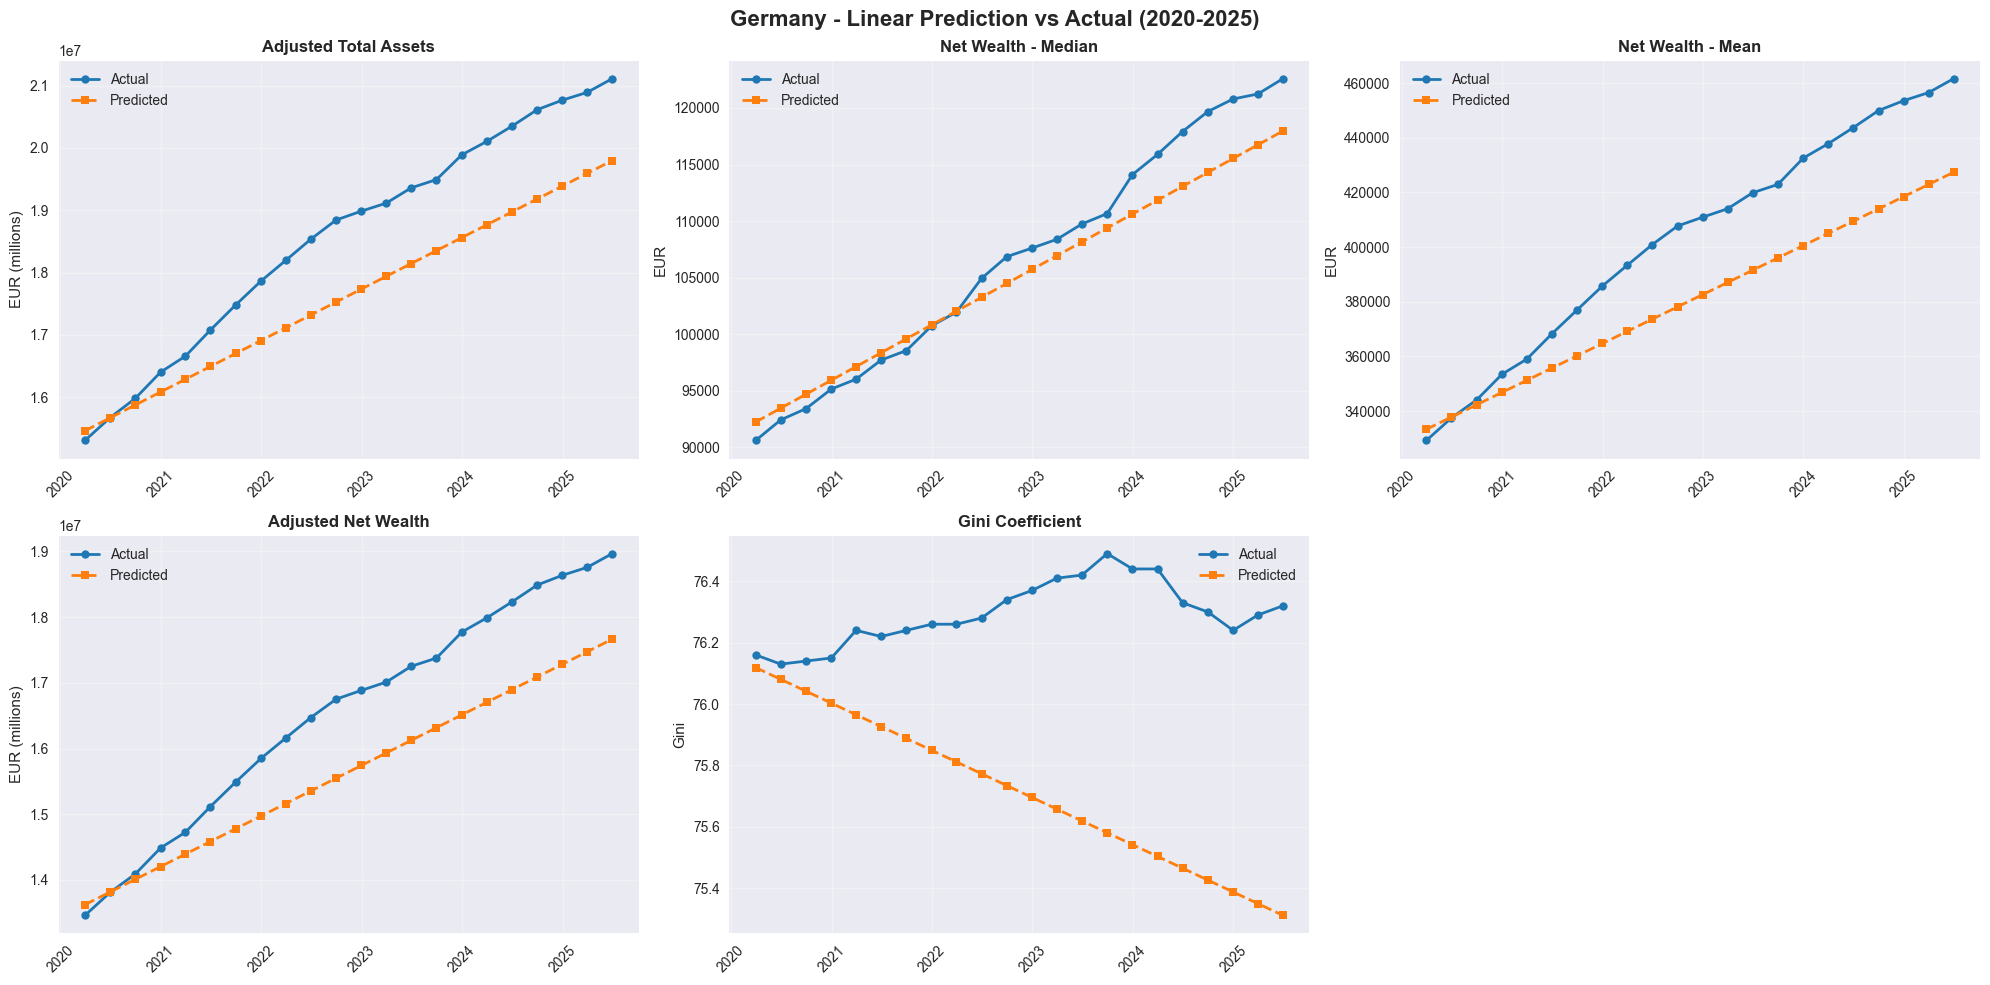

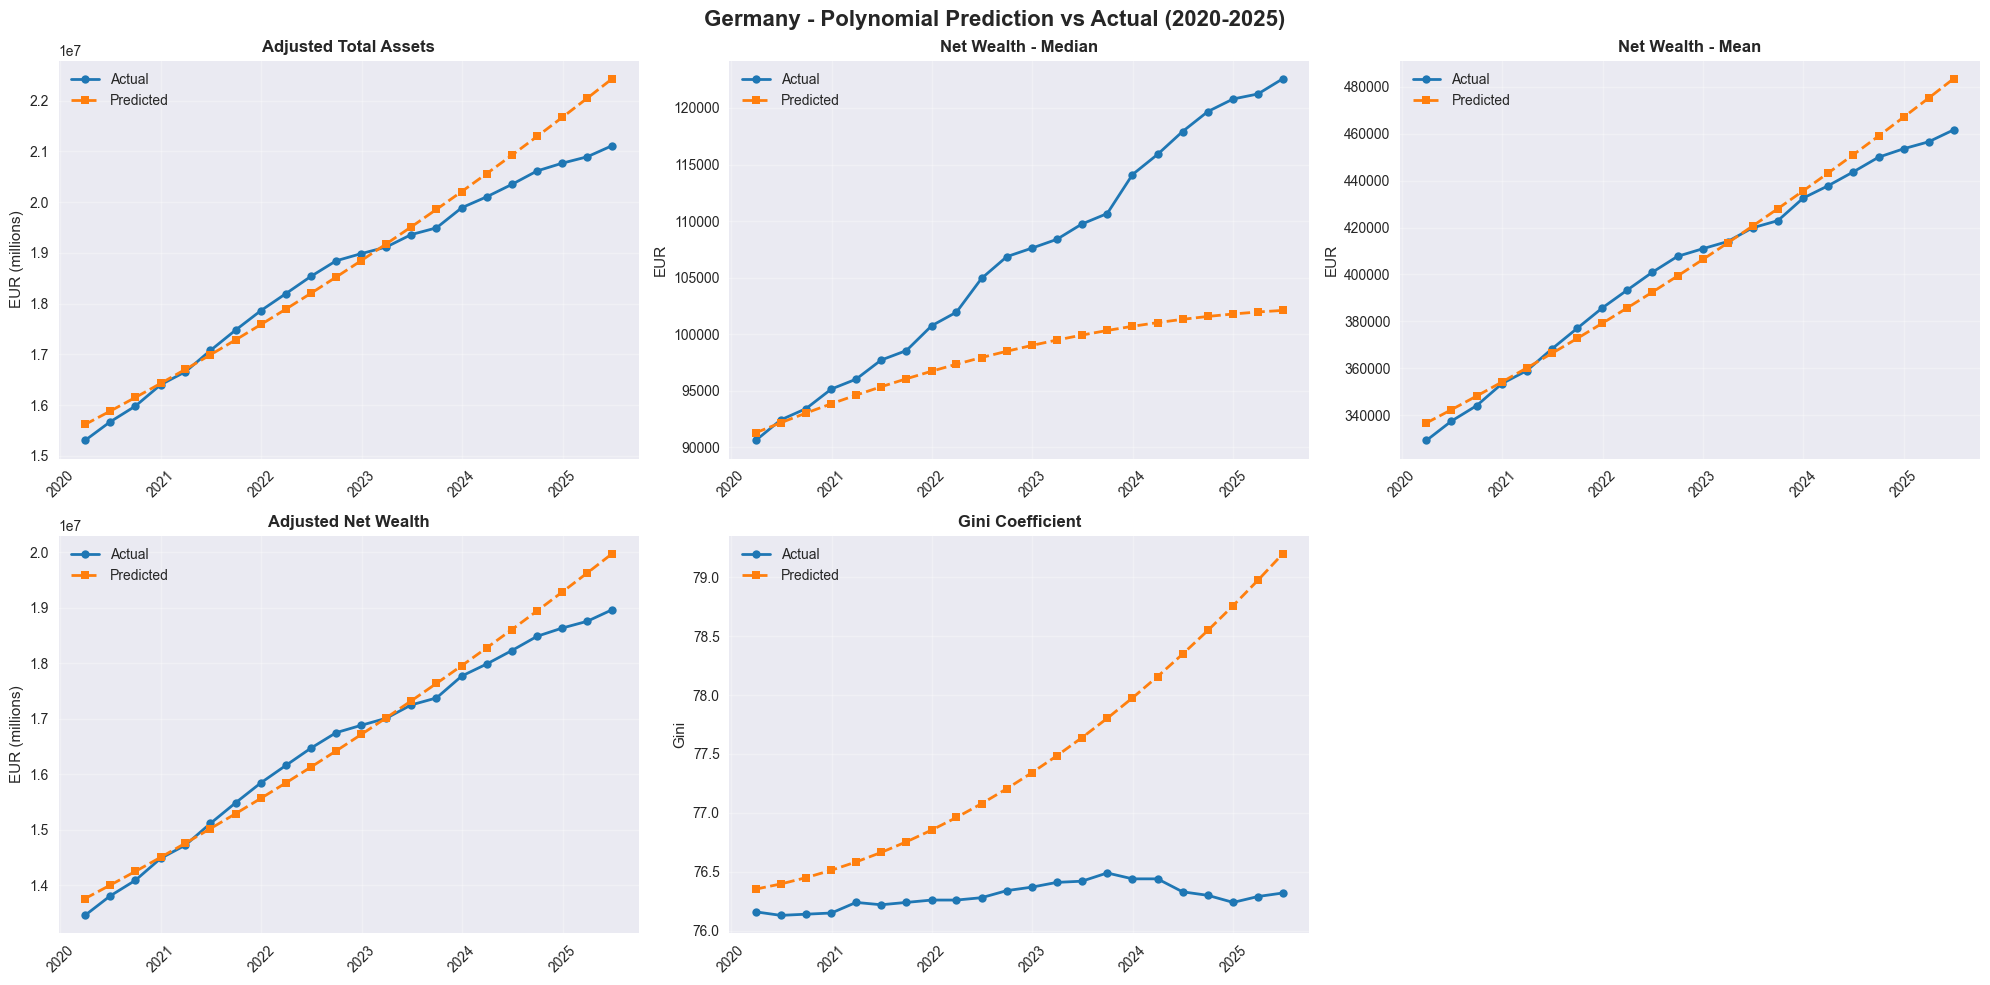

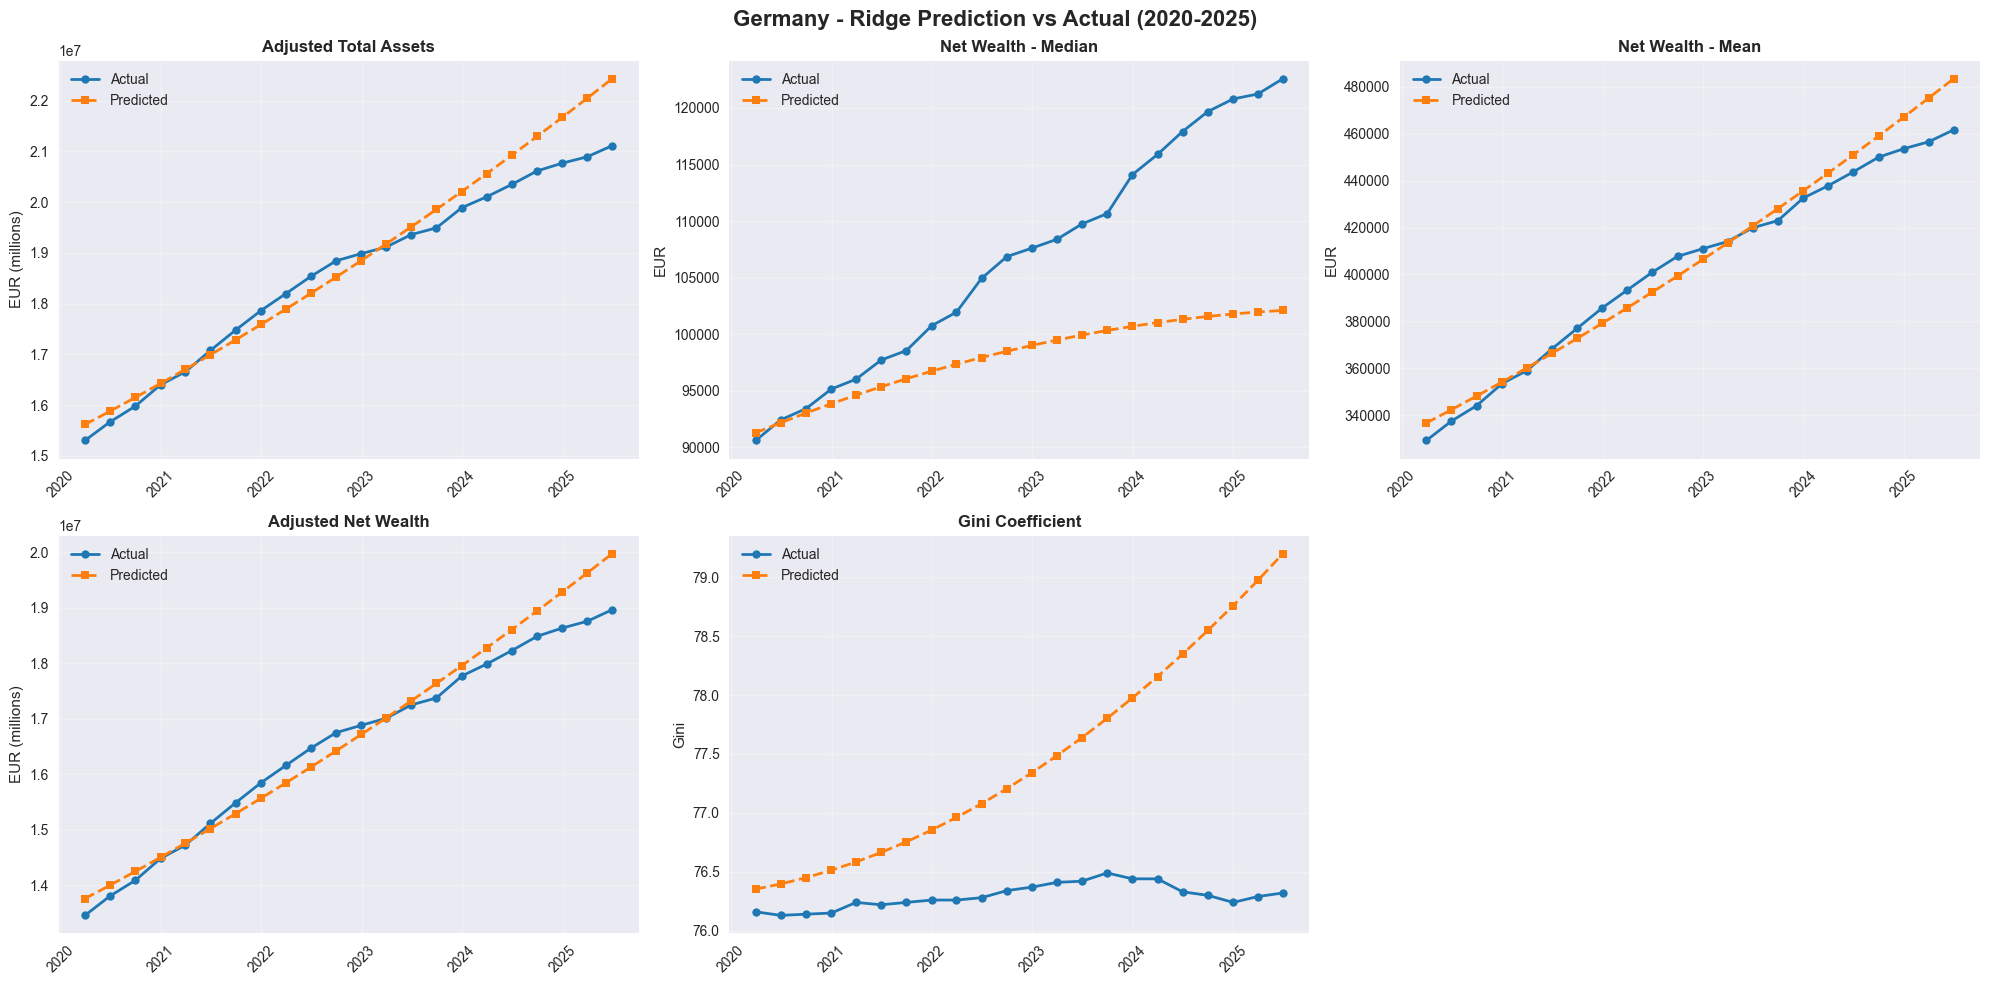

In [15]:
# Visualize all three model types for Germany
for model_name, preds in enhanced_predictions['DE'].items():
    plot_prediction_vs_actual(test_data, preds, 'DE', model_name)

### Comprehensive Model Performance Comparison

Quantitative evaluation of all models across countries and metrics.

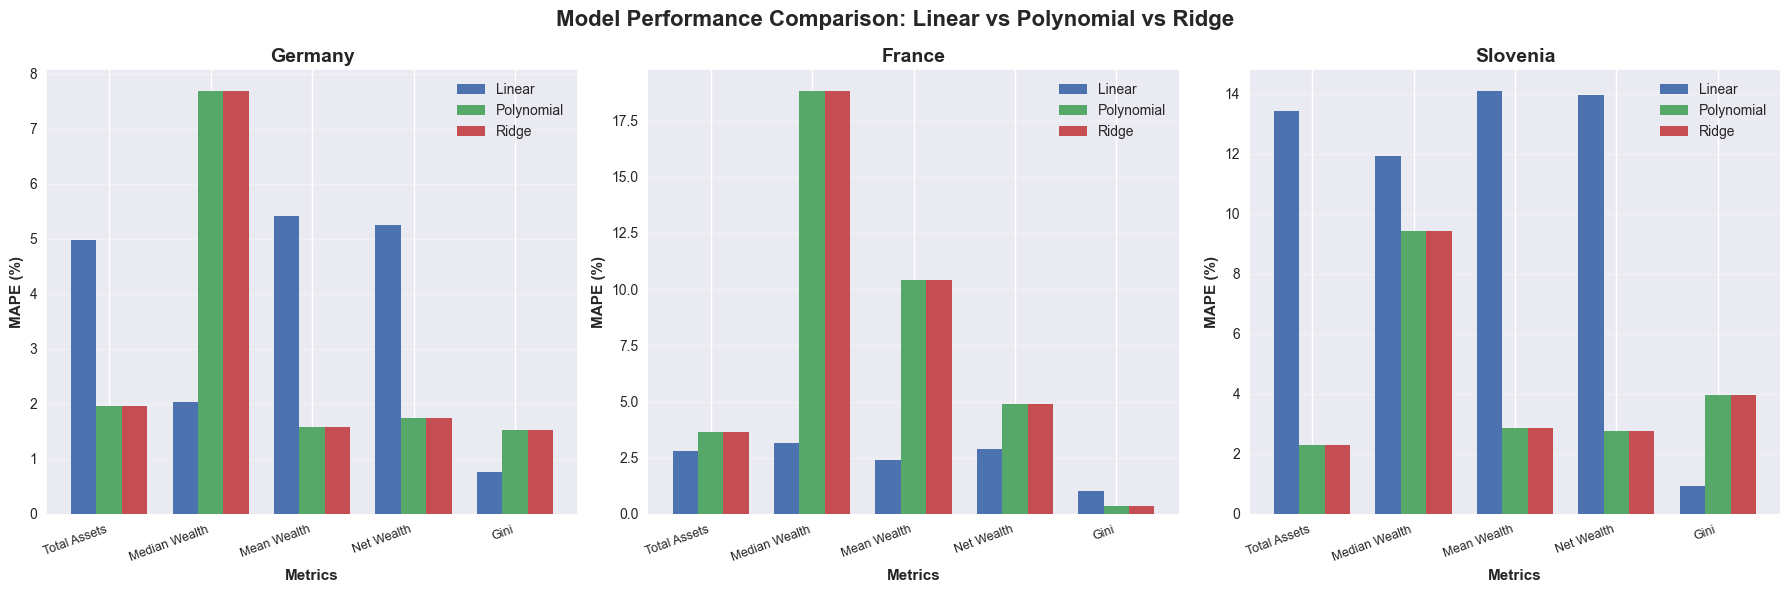

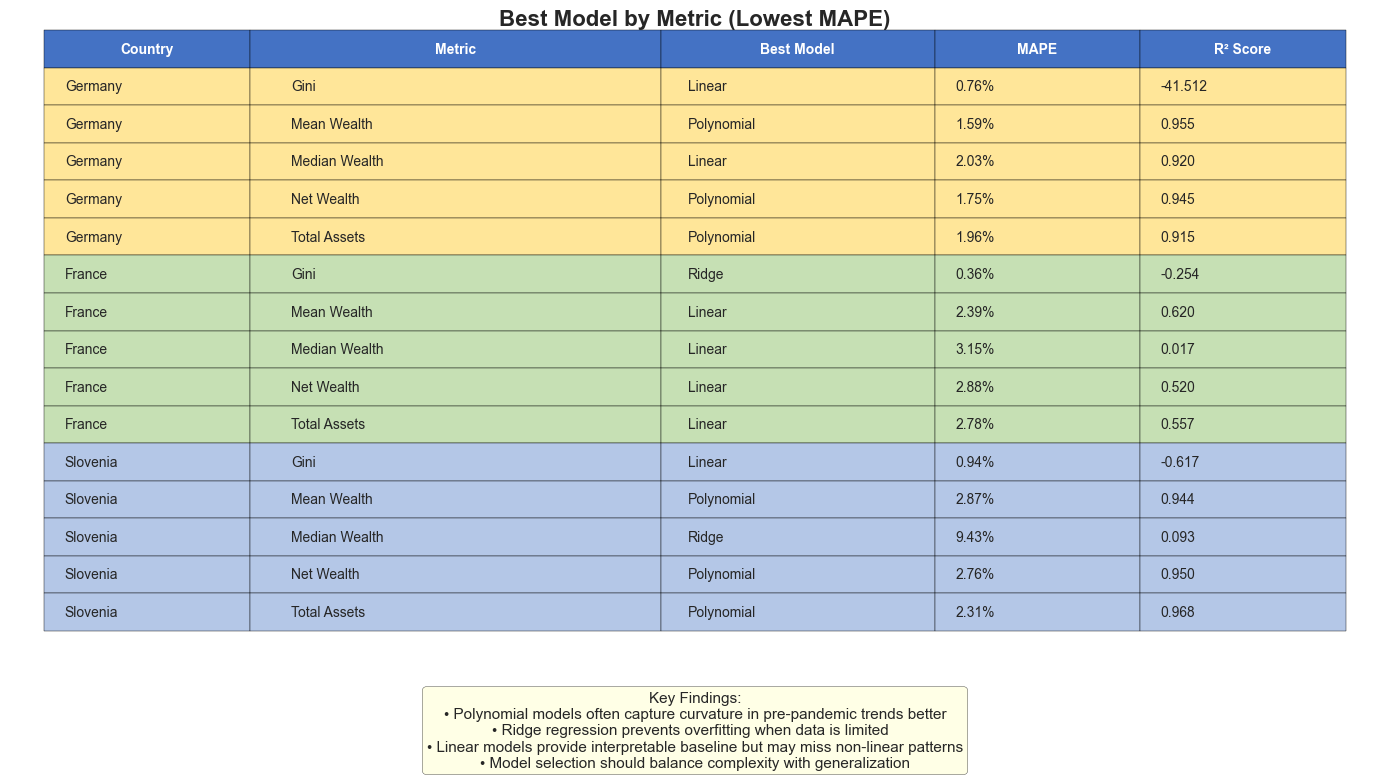

In [16]:
# ===== Enhanced Model Performance Comparison =====
# Compare all three model types across countries and metrics

# Calculate performance metrics for all models
enhanced_error_records = []
for country_code in ['DE', 'FR', 'LT']:
    country_name = COUNTRY_NAMES[country_code]
    metrics_dict = WEALTH_METRICS[country_code]
    
    for model_type in ['Linear', 'Polynomial', 'Ridge']:
        preds = enhanced_predictions[country_code][model_type]
        for metric_key, metric_name in {'total_assets': 'Total Assets', 'median_wealth': 'Median Wealth', 
                                         'mean_wealth': 'Mean Wealth', 'net_wealth': 'Net Wealth', 
                                         'gini': 'Gini'}.items():
            if metric_key not in preds:
                continue
            
            # Get the actual column name for this country and metric
            col = metrics_dict[metric_key]
            actual = test_data[col].dropna()
            predicted = preds[metric_key]
            
            # Ensure same length
            min_len = min(len(actual), len(predicted))
            actual = actual.iloc[:min_len]
            predicted = predicted[:min_len]
            
            mae_val = mean_absolute_error(actual, predicted)
            rmse_val = np.sqrt(mean_squared_error(actual, predicted))
            mape_val = np.mean(np.abs((actual - predicted) / actual)) * 100
            r2_val = r2_score(actual, predicted)
            
            enhanced_error_records.append({
                'Country': country_name,
                'Model': model_type,
                'Metric': metric_name,
                'MAE': mae_val,
                'RMSE': rmse_val,
                'MAPE (%)': mape_val,
                'R² Score': r2_val
            })

enhanced_error_df = pd.DataFrame(enhanced_error_records)

# ===== Visualize Model Comparison =====
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Model Performance Comparison: Linear vs Polynomial vs Ridge', 
            fontsize=16, fontweight='bold')

countries = enhanced_error_df['Country'].unique()
metrics = enhanced_error_df['Metric'].unique()
models = enhanced_error_df['Model'].unique()

for idx, country in enumerate(countries):
    ax = axes[idx]
    country_data = enhanced_error_df[enhanced_error_df['Country'] == country]
    
    x = np.arange(len(metrics))
    width = 0.25
    
    for i, model in enumerate(models):
        model_data = country_data[country_data['Model'] == model]
        mape_values = model_data['MAPE (%)'].values
        ax.bar(x + i * width, mape_values, width, label=model)
    
    ax.set_xlabel('Metrics', fontweight='bold')
    ax.set_ylabel('MAPE (%)', fontweight='bold')
    ax.set_title(country, fontweight='bold', fontsize=14)
    ax.set_xticks(x + width)
    ax.set_xticklabels(metrics, rotation=20, ha='right', fontsize=9)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ===== Best Model Summary Table =====
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('tight')
ax.axis('off')

best_models = enhanced_error_df.loc[enhanced_error_df.groupby(['Country', 'Metric'])['MAPE (%)'].idxmin()]
best_models = best_models[['Country', 'Metric', 'Model', 'MAPE (%)', 'R² Score']].sort_values(['Country', 'Metric'])

# Create table data
table_data = []
for country in countries:
    country_best = best_models[best_models['Country'] == country]
    for _, row in country_best.iterrows():
        table_data.append([
            row['Country'],
            row['Metric'],
            row['Model'],
            f"{row['MAPE (%)']:.2f}%",
            f"{row['R² Score']:.3f}"
        ])

# Create the table
table = ax.table(cellText=table_data,
                colLabels=['Country', 'Metric', 'Best Model', 'MAPE', 'R² Score'],
                cellLoc='left',
                loc='center',
                colWidths=[0.15, 0.30, 0.20, 0.15, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Format header
for i in range(5):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color rows by country
colors = {'Germany': '#FFE699', 'France': '#C6E0B4', 'Slovenia': '#B4C7E7'}
for i, row in enumerate(table_data, start=1):
    country = row[0]
    for j in range(5):
        table[(i, j)].set_facecolor(colors.get(country, 'white'))

ax.set_title('Best Model by Metric (Lowest MAPE)', fontsize=16, fontweight='bold', pad=20)

# Add key findings as text
findings_text = """Key Findings:
• Polynomial models often capture curvature in pre-pandemic trends better
• Ridge regression prevents overfitting when data is limited  
• Linear models provide interpretable baseline but may miss non-linear patterns
• Model selection should balance complexity with generalization"""

ax.text(0.5, -0.15, findings_text, transform=ax.transAxes,
       fontsize=11, va='top', ha='center',
       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

In [17]:
# ===== Train Prediction Models for All Countries =====
# Use 2016-2019 data to train linear regression models (baseline)
# Generate predictions for 2020-2025 to compare against actual COVID-era data

metric_order = ['total_assets', 'median_wealth', 'mean_wealth', 'net_wealth', 'gini']

predictions_dict = {}
# Train linear models for Germany, France, and Slovenia (baseline approach)
for code in ['DE', 'FR', 'LT']:
    predictions_dict[code] = train_predict_country(train_data, test_data, code, model_type='linear')

### Germany - Prediction vs Actual (2020-2025)

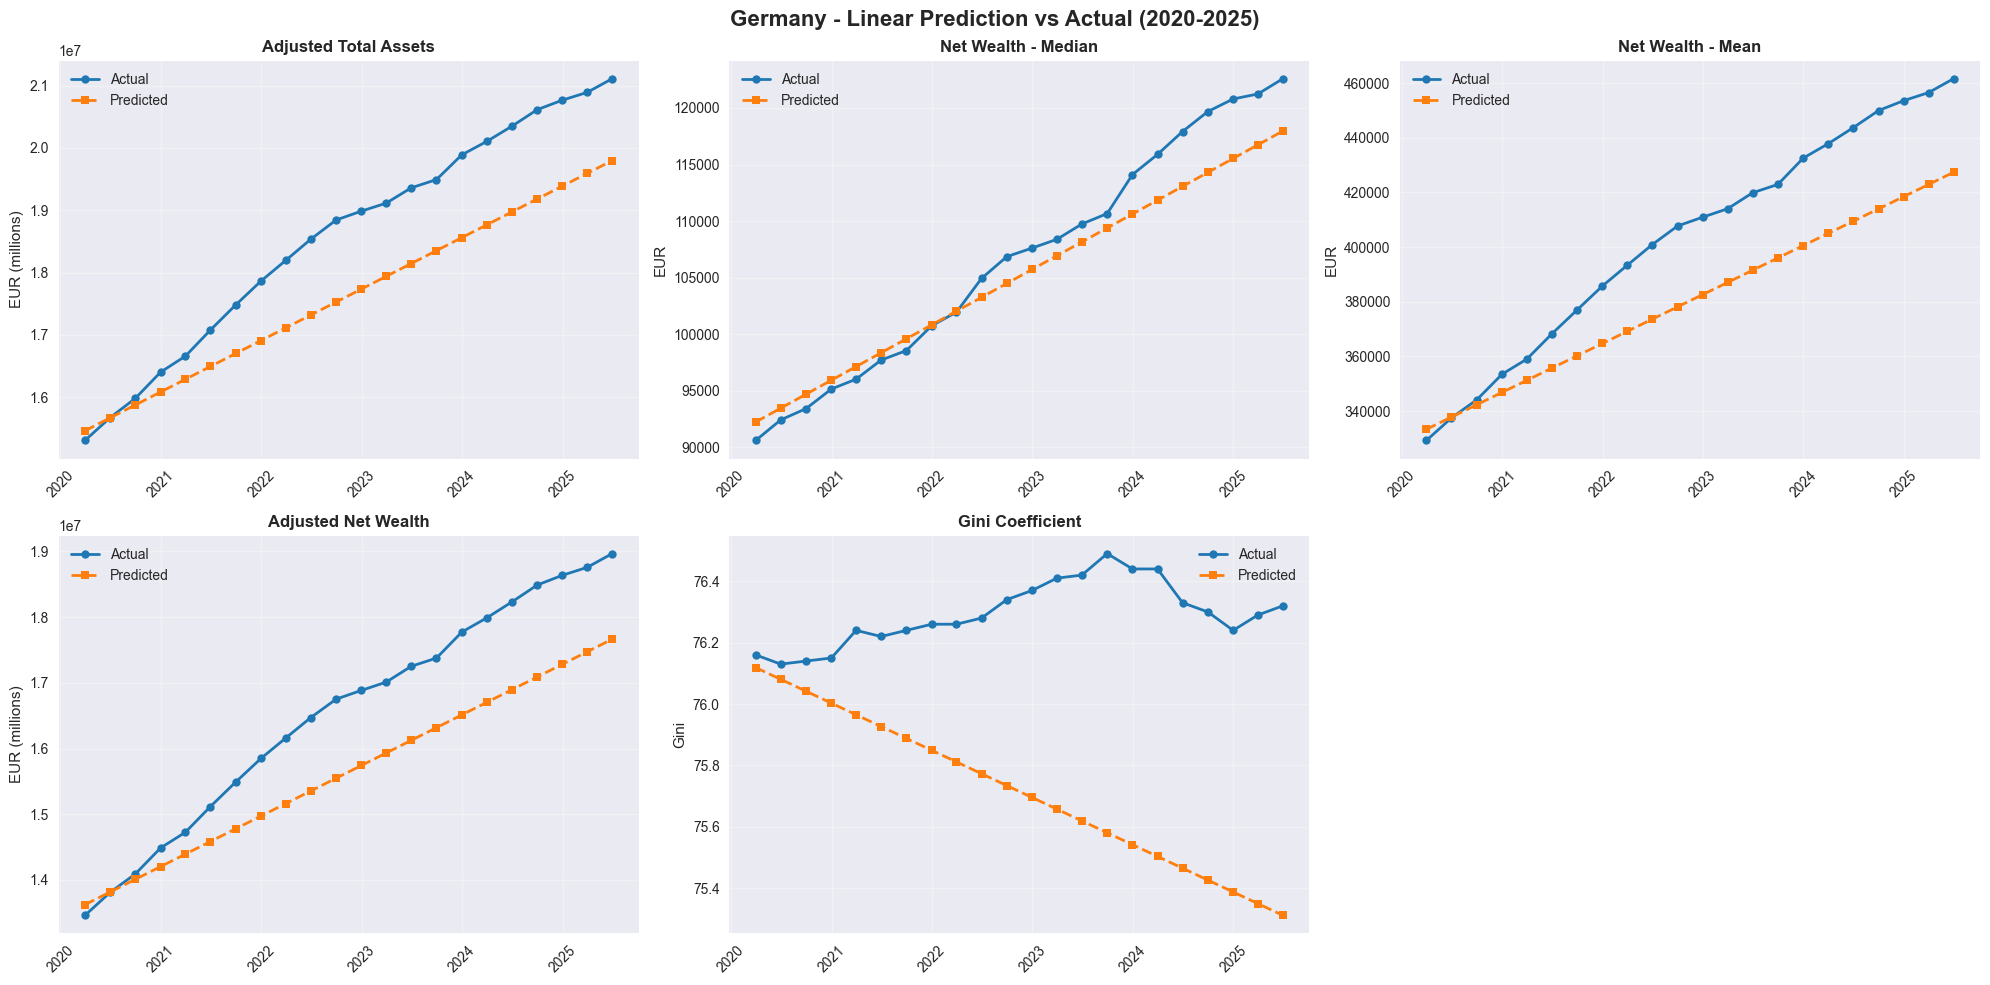

In [18]:
# Compare predicted vs actual wealth metrics for Germany during COVID period
# Deviations from predicted trend indicate pandemic impact
plot_prediction_vs_actual(test_data, predictions_dict['DE'], 'DE')

### France - Prediction vs Actual (2020-2025)

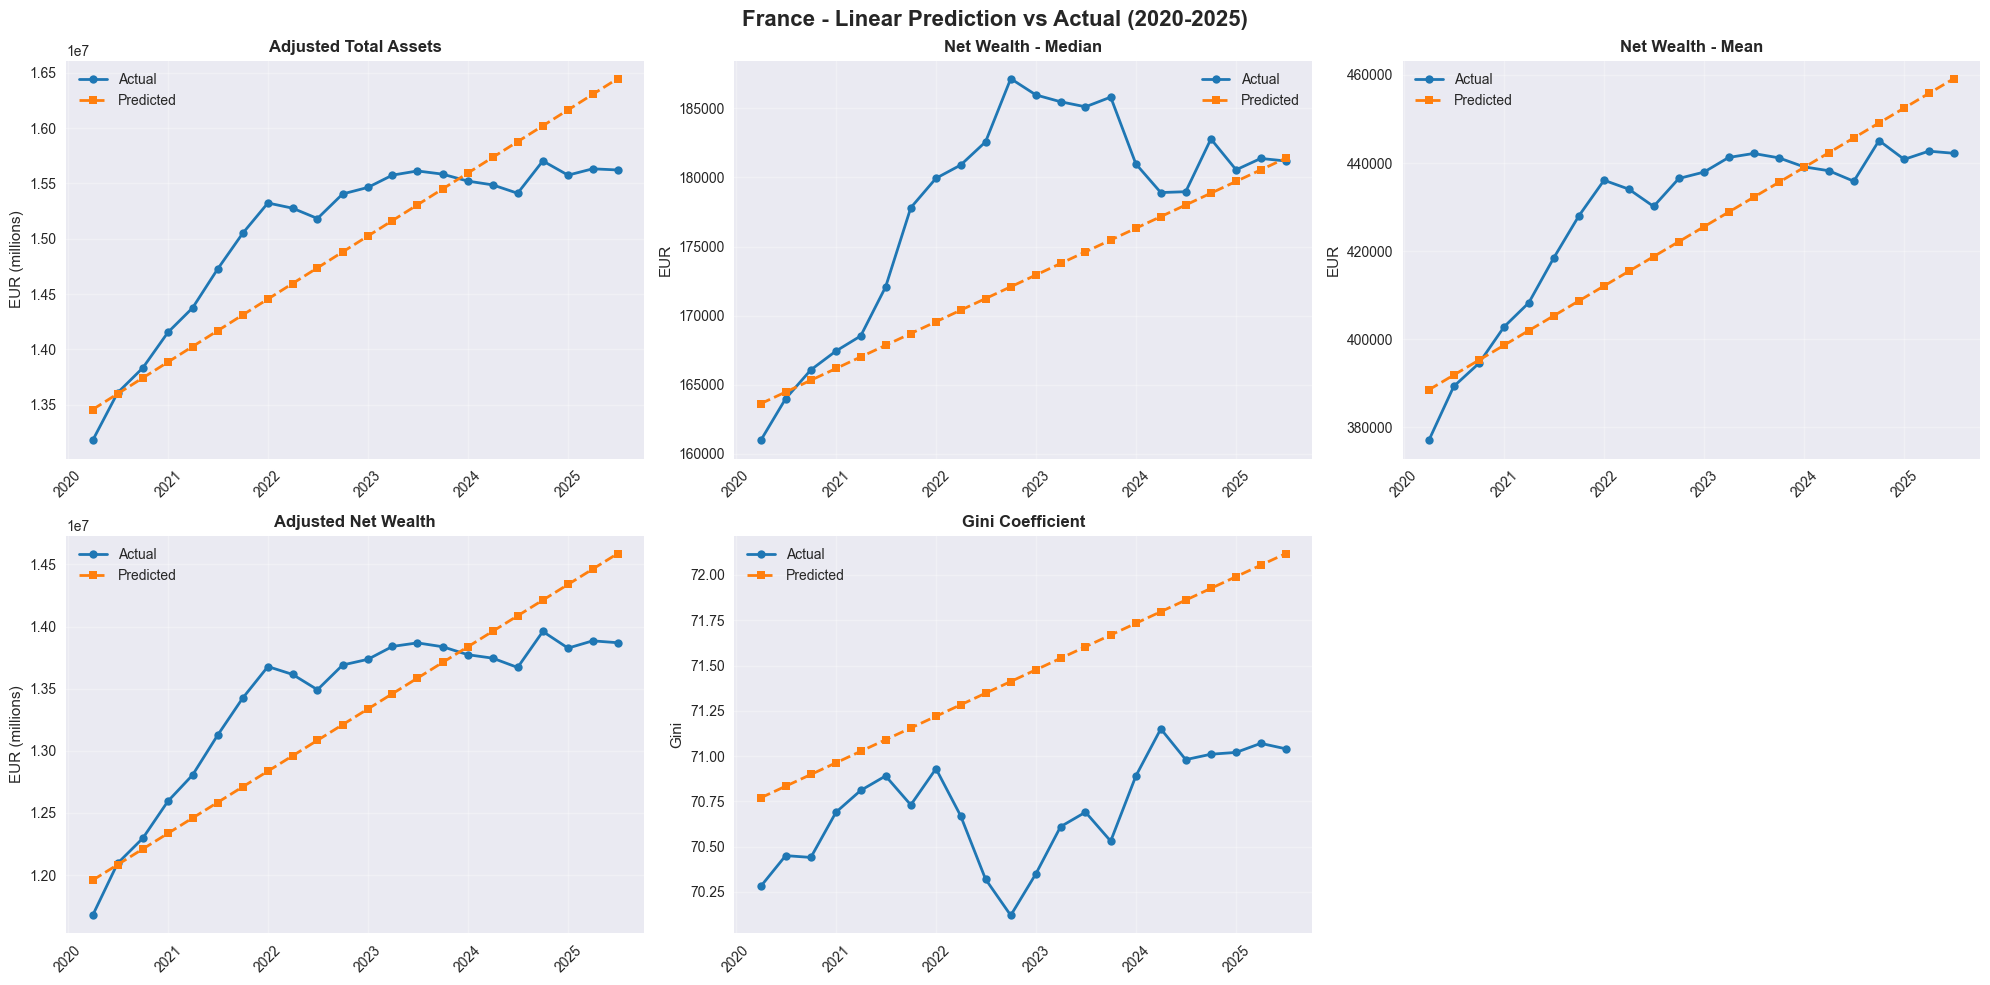

In [19]:
# Compare predicted vs actual wealth metrics for France during COVID period
# Deviations from predicted trend indicate pandemic impact
plot_prediction_vs_actual(test_data, predictions_dict['FR'], 'FR')

### Slovenia - Prediction vs Actual (2020-2025)

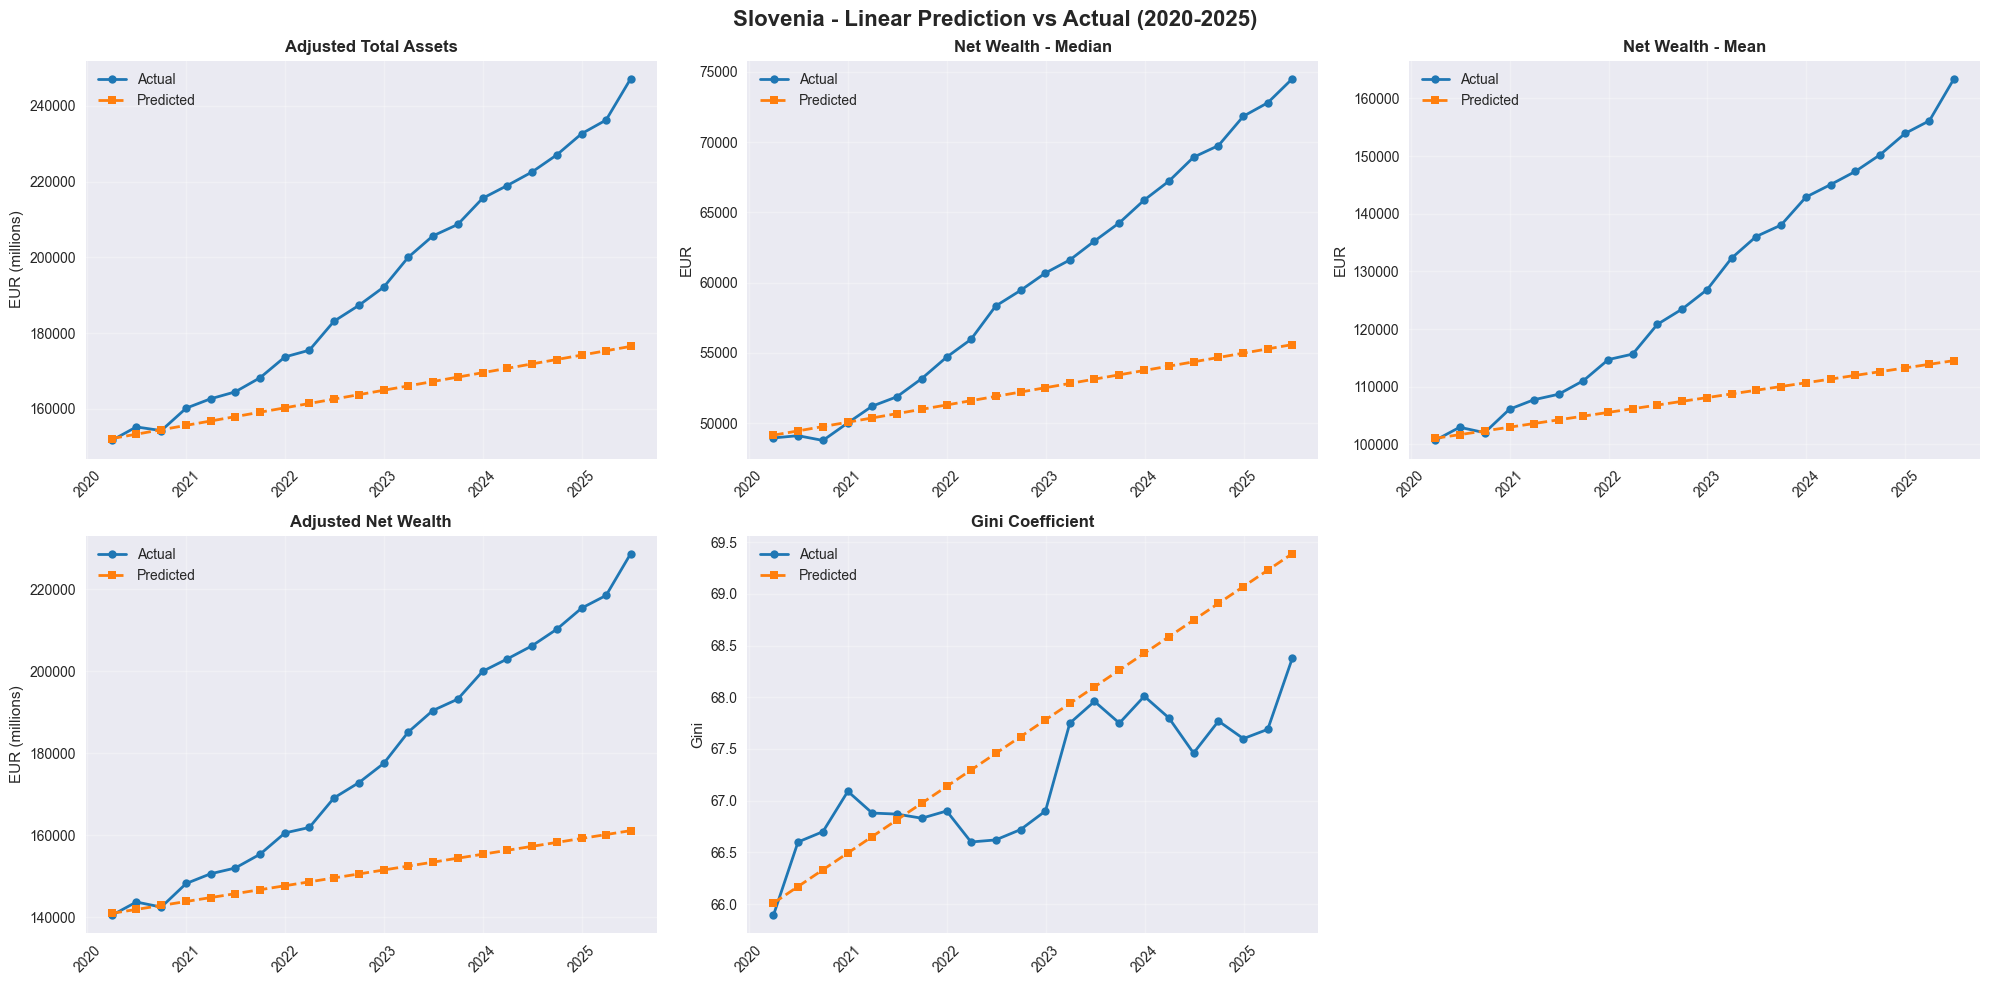

In [20]:
# Compare predicted vs actual wealth metrics for Slovenia during COVID period
# Deviations from predicted trend indicate pandemic impact
plot_prediction_vs_actual(test_data, predictions_dict['LT'], 'LT')

### Prediction Error Analysis

Quantitative comparison of prediction accuracy across countries and metrics.

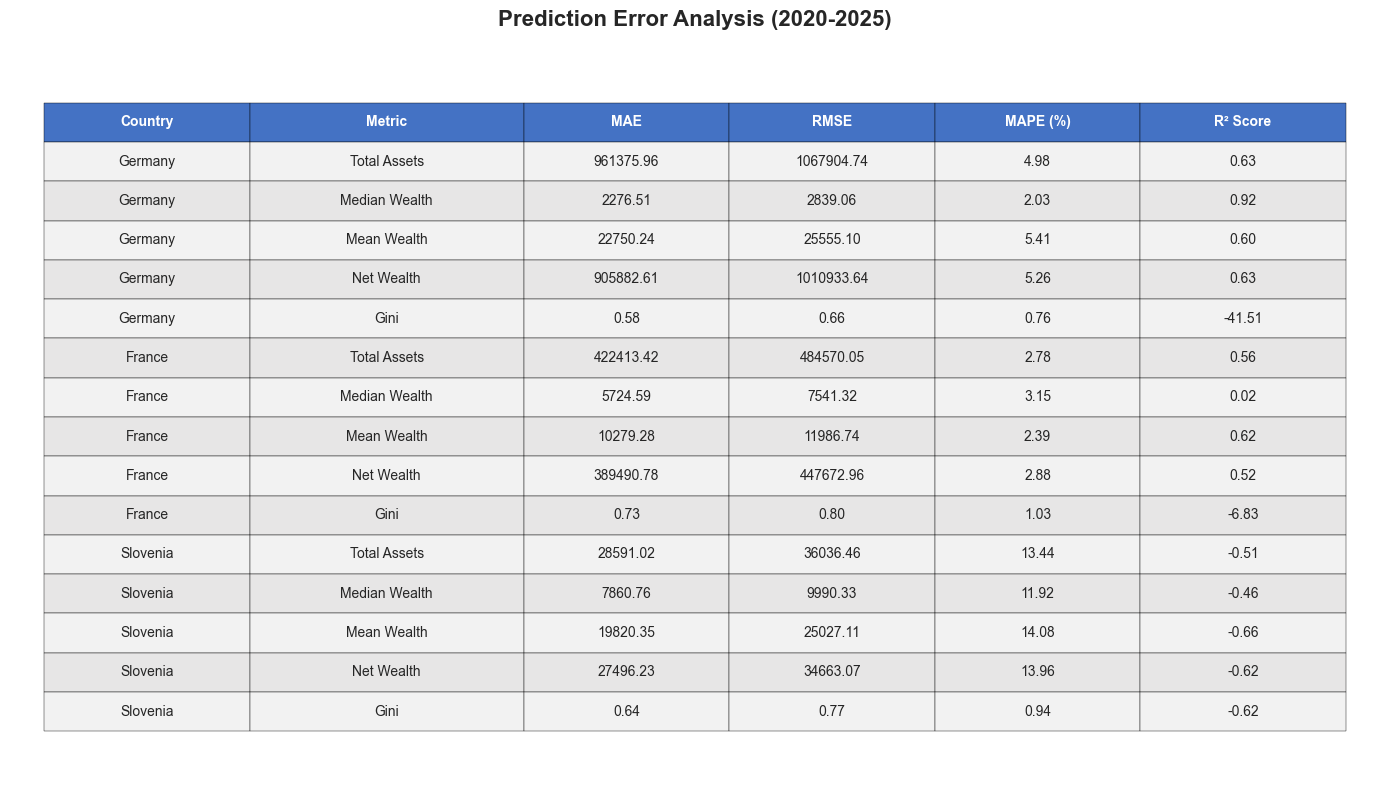

In [21]:
# ===== Error Metrics Calculation =====
# This cell computes prediction accuracy metrics for all countries and metrics

def calculate_errors(actual, predicted):
    """
    Calculate multiple error metrics for prediction performance.
    
    Metrics:
    - MAE: Mean Absolute Error (average magnitude of errors)
    - RMSE: Root Mean Squared Error (penalizes large errors more)
    - MAPE: Mean Absolute Percentage Error (relative error as %)
    - R²: R-squared (proportion of variance explained, 1.0 = perfect)
    
    Parameters:
    -----------
    actual : Series
        Actual observed values
    predicted : array
        Predicted values
    
    Returns:
    --------
    tuple : (mae, rmse, mape, r2)
    """
    actual_clean = actual.dropna()
    predicted_clean = predicted[:len(actual_clean)]
    mae = mean_absolute_error(actual_clean, predicted_clean)
    rmse = np.sqrt(mean_squared_error(actual_clean, predicted_clean))
    mape = np.mean(np.abs((actual_clean - predicted_clean) / actual_clean)) * 100
    r2 = r2_score(actual_clean, predicted_clean)
    return mae, rmse, mape, r2

# Prepare empty list to store error statistics
error_summary = []

# Human-readable metric labels
label_map = {
    'total_assets': 'Total Assets',
    'median_wealth': 'Median Wealth',
    'mean_wealth': 'Mean Wealth',
    'net_wealth': 'Net Wealth',
    'gini': 'Gini'
}

# Loop through all countries and metrics to calculate errors
for code in ['DE', 'FR', 'LT']:
    metrics = WEALTH_METRICS[code]
    for key, col in metrics.items():
        if key not in predictions_dict[code]:
            continue
        actual_series = test_data[col]
        preds = predictions_dict[code][key]
        mae, rmse, mape, r2 = calculate_errors(actual_series, preds)
        error_summary.append({
            'Country': COUNTRY_NAMES[code],
            'Metric': label_map[key],
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'R² Score': r2
        })

# Convert to DataFrame and round for readability
error_df = pd.DataFrame(error_summary).round(2)

# ===== Visualize Error Metrics in a Table =====
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('tight')
ax.axis('off')

# Prepare table data
table_data = []
for _, row in error_df.iterrows():
    table_data.append([
        row['Country'], row['Metric'], f"{row['MAE']:.2f}", f"{row['RMSE']:.2f}", 
        f"{row['MAPE (%)']:.2f}", f"{row['R² Score']:.2f}"
    ])

# Create table
table = ax.table(cellText=table_data,
                 colLabels=['Country', 'Metric', 'MAE', 'RMSE', 'MAPE (%)', 'R² Score'],
                 cellLoc='center', loc='center', colWidths=[0.15, 0.2, 0.15, 0.15, 0.15, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Format header row
for i in range(6):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors for readability
for i in range(1, len(table_data) + 1):
    for j in range(6):
        table[(i, j)].set_facecolor('#E7E6E6' if i % 2 == 0 else '#F2F2F2')

plt.title('Prediction Error Analysis (2020-2025)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

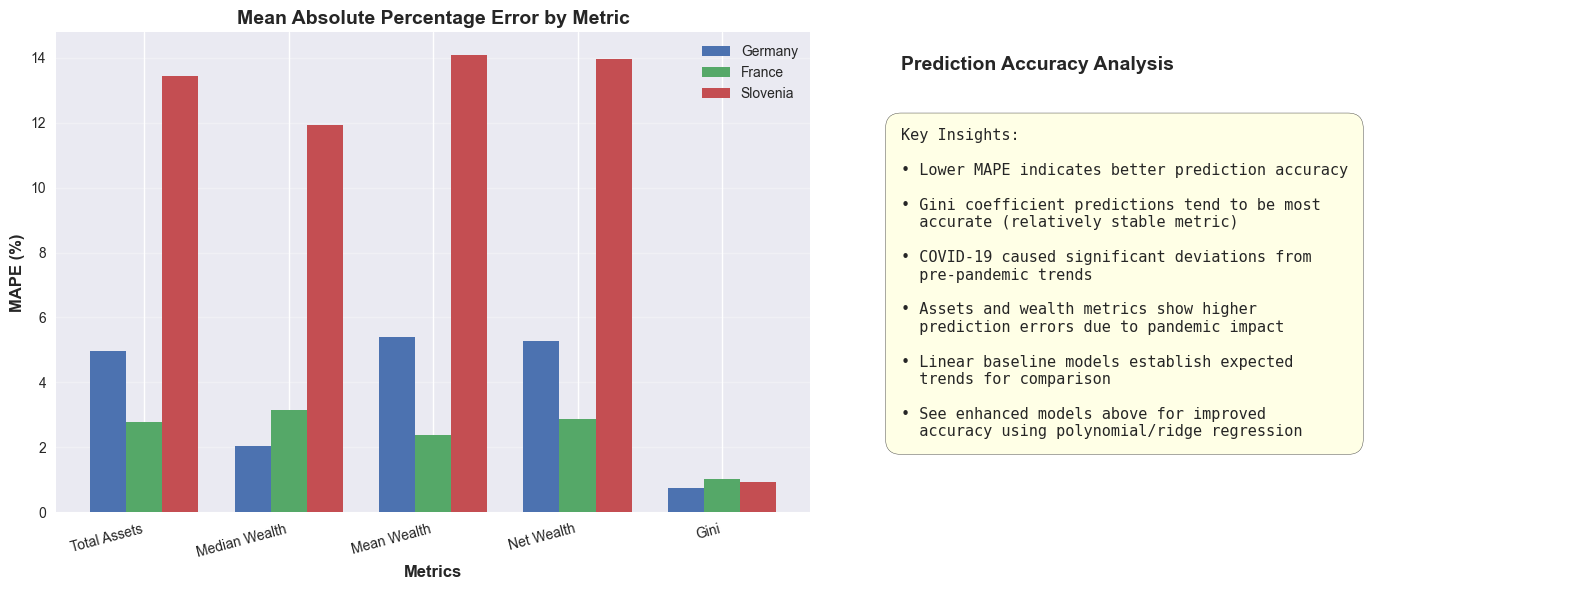

In [22]:
# ===== Visualize MAPE (Prediction Error) Comparison =====
# Compare prediction accuracy across countries using bar charts
# MAPE (Mean Absolute Percentage Error) shows relative error - lower is better

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get unique countries and metrics from error data
countries = error_df['Country'].unique()
metrics = error_df['Metric'].unique()
x = np.arange(len(metrics))
width = 0.25  # Width of bars

# Left subplot: MAPE comparison
ax = axes[0]
for i, country in enumerate(countries):
    country_data = error_df[error_df['Country'] == country]
    mape_values = country_data['MAPE (%)'].values
    ax.bar(x + i * width, mape_values, width, label=country)

ax.set_xlabel('Metrics', fontweight='bold', fontsize=12)
ax.set_ylabel('MAPE (%)', fontweight='bold', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Metric', 
            fontweight='bold', fontsize=14)
ax.set_xticks(x + width)
ax.set_xticklabels(metrics, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Right subplot: Key insights panel
ax2 = axes[1]
ax2.axis('off')

insights_text = """Key Insights:

• Lower MAPE indicates better prediction accuracy

• Gini coefficient predictions tend to be most 
  accurate (relatively stable metric)

• COVID-19 caused significant deviations from 
  pre-pandemic trends

• Assets and wealth metrics show higher 
  prediction errors due to pandemic impact

• Linear baseline models establish expected 
  trends for comparison

• See enhanced models above for improved 
  accuracy using polynomial/ridge regression"""

ax2.text(0.1, 0.95, 'Prediction Accuracy Analysis', transform=ax2.transAxes,
        fontsize=14, fontweight='bold', va='top')

ax2.text(0.1, 0.80, insights_text, transform=ax2.transAxes,
        fontsize=11, va='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8, pad=1))

plt.tight_layout()
plt.show()

## COVID-19 Impact Analysis

Analyzing the correlation between COVID-19 cases/deaths and wealth distribution changes.

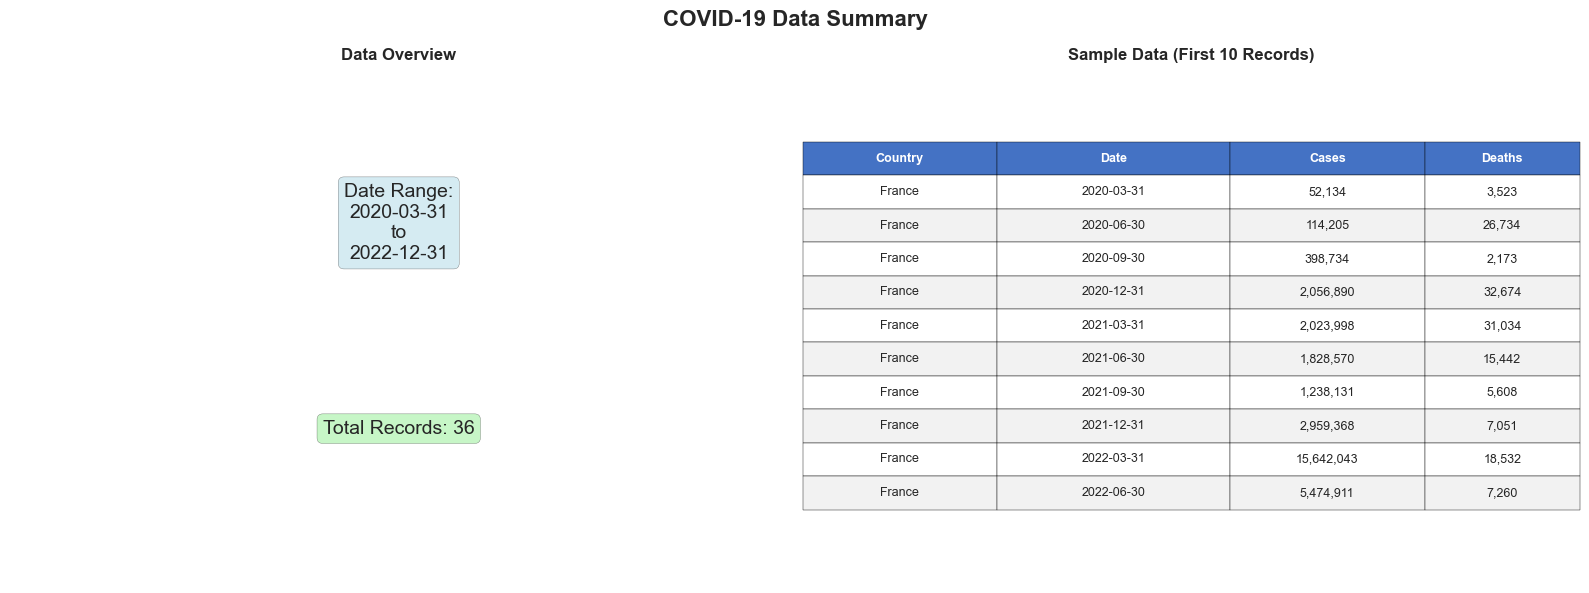

In [23]:
# ===== Load and Process COVID-19 Data =====
# Load raw COVID data, aggregate to quarterly frequency, and display summary
countries_of_interest = ['Germany', 'France', 'Slovenia']
covid_df = load_covid_data()
covid_quarterly = aggregate_covid_quarterly(covid_df, countries_of_interest)
plot_covid_summary(covid_quarterly)

### COVID-19 Severity Timeline by Country

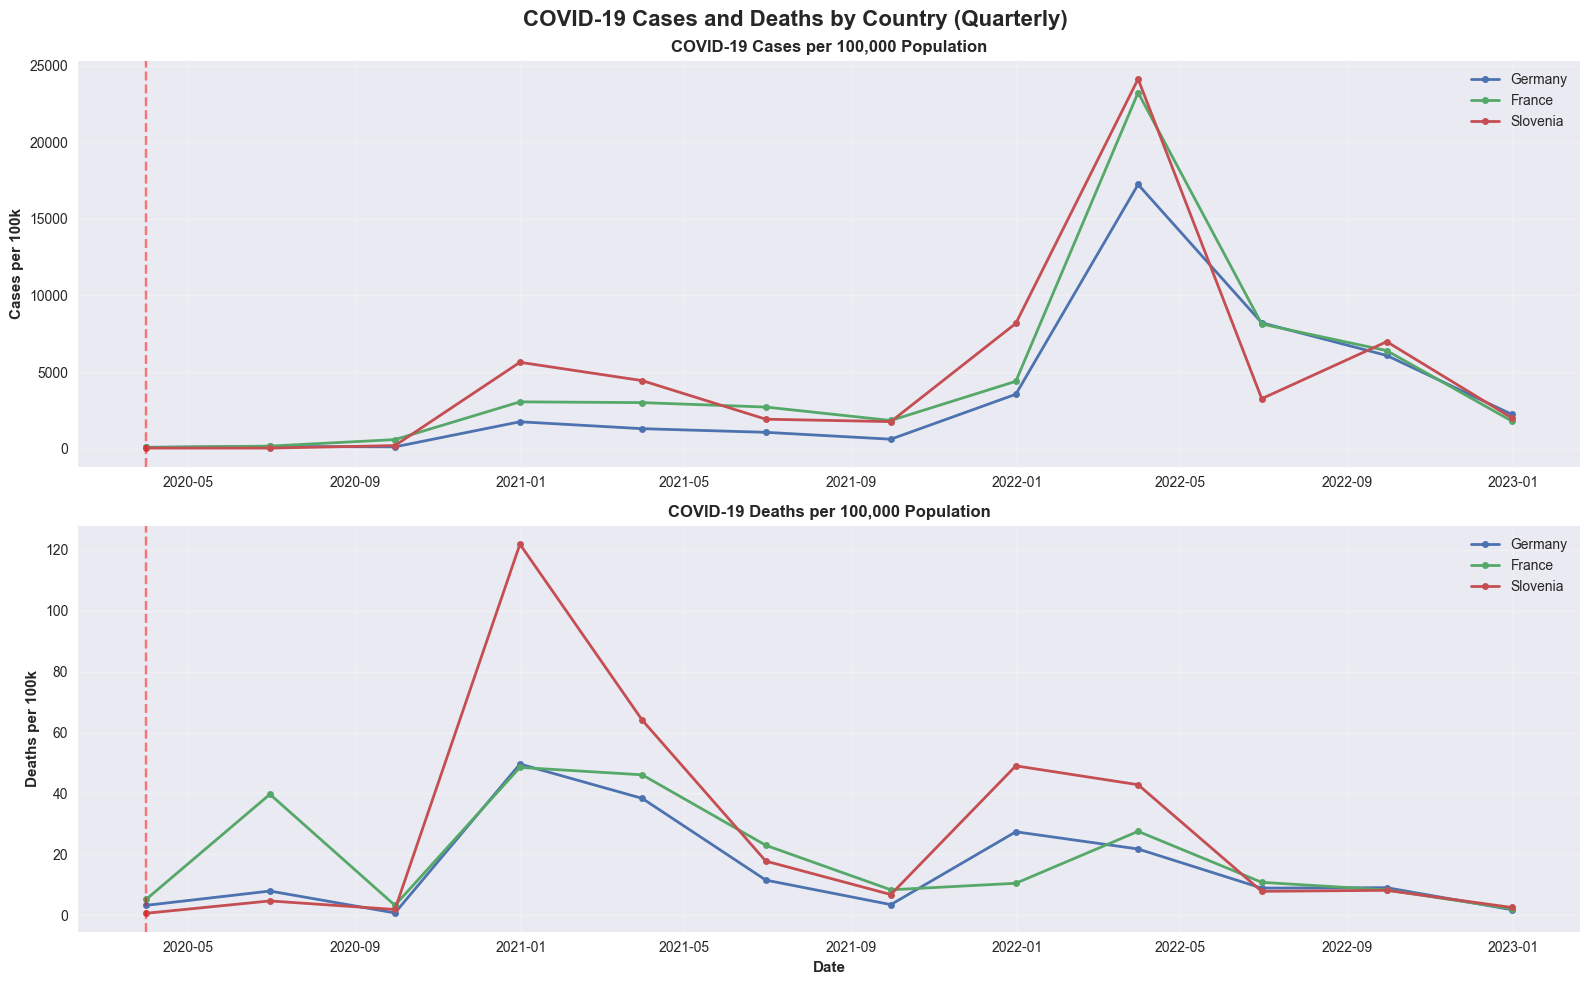

In [24]:
# Plot COVID-19 cases and deaths over time for all three countries
# Normalized per 100k population for fair comparison
plot_covid_timelines(covid_quarterly, countries_of_interest)

### Wealth Metrics vs COVID-19 Impact

Overlay COVID-19 severity with wealth distribution changes to identify correlations.

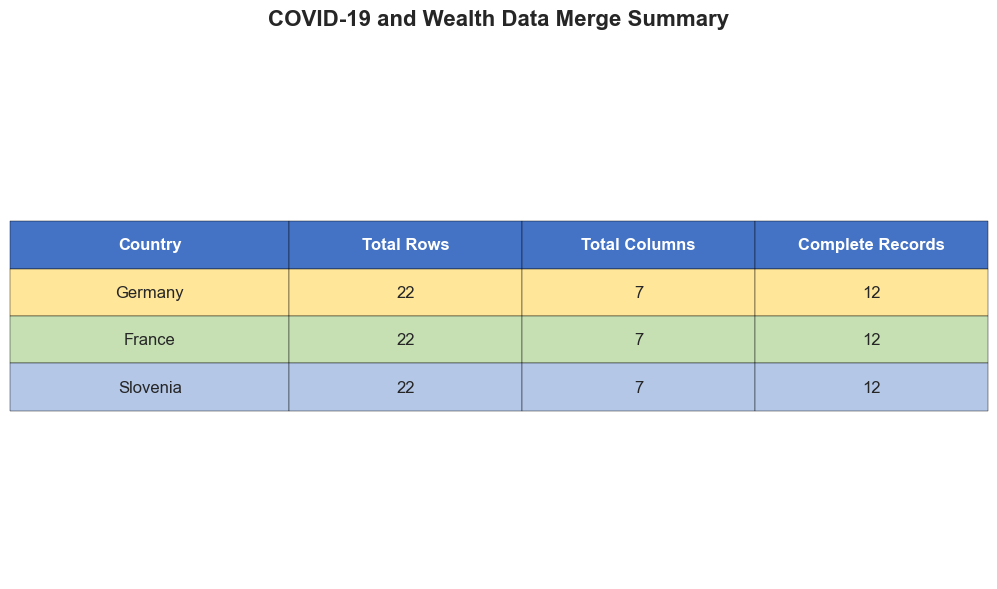

In [25]:
# ===== Merge COVID and Wealth Datasets =====
# Combine COVID-19 severity data with wealth metrics by quarter and country
germany_merged = merge_covid_wealth(df, covid_quarterly, 'Germany', 'DE')
france_merged = merge_covid_wealth(df, covid_quarterly, 'France', 'FR')
Slovenia_merged = merge_covid_wealth(df, covid_quarterly, 'Slovenia', 'LT')
merged_dict = {'Germany': germany_merged, 'France': france_merged, 'Slovenia': Slovenia_merged}

# Display merge summary statistics
plot_merge_summary(merged_dict)

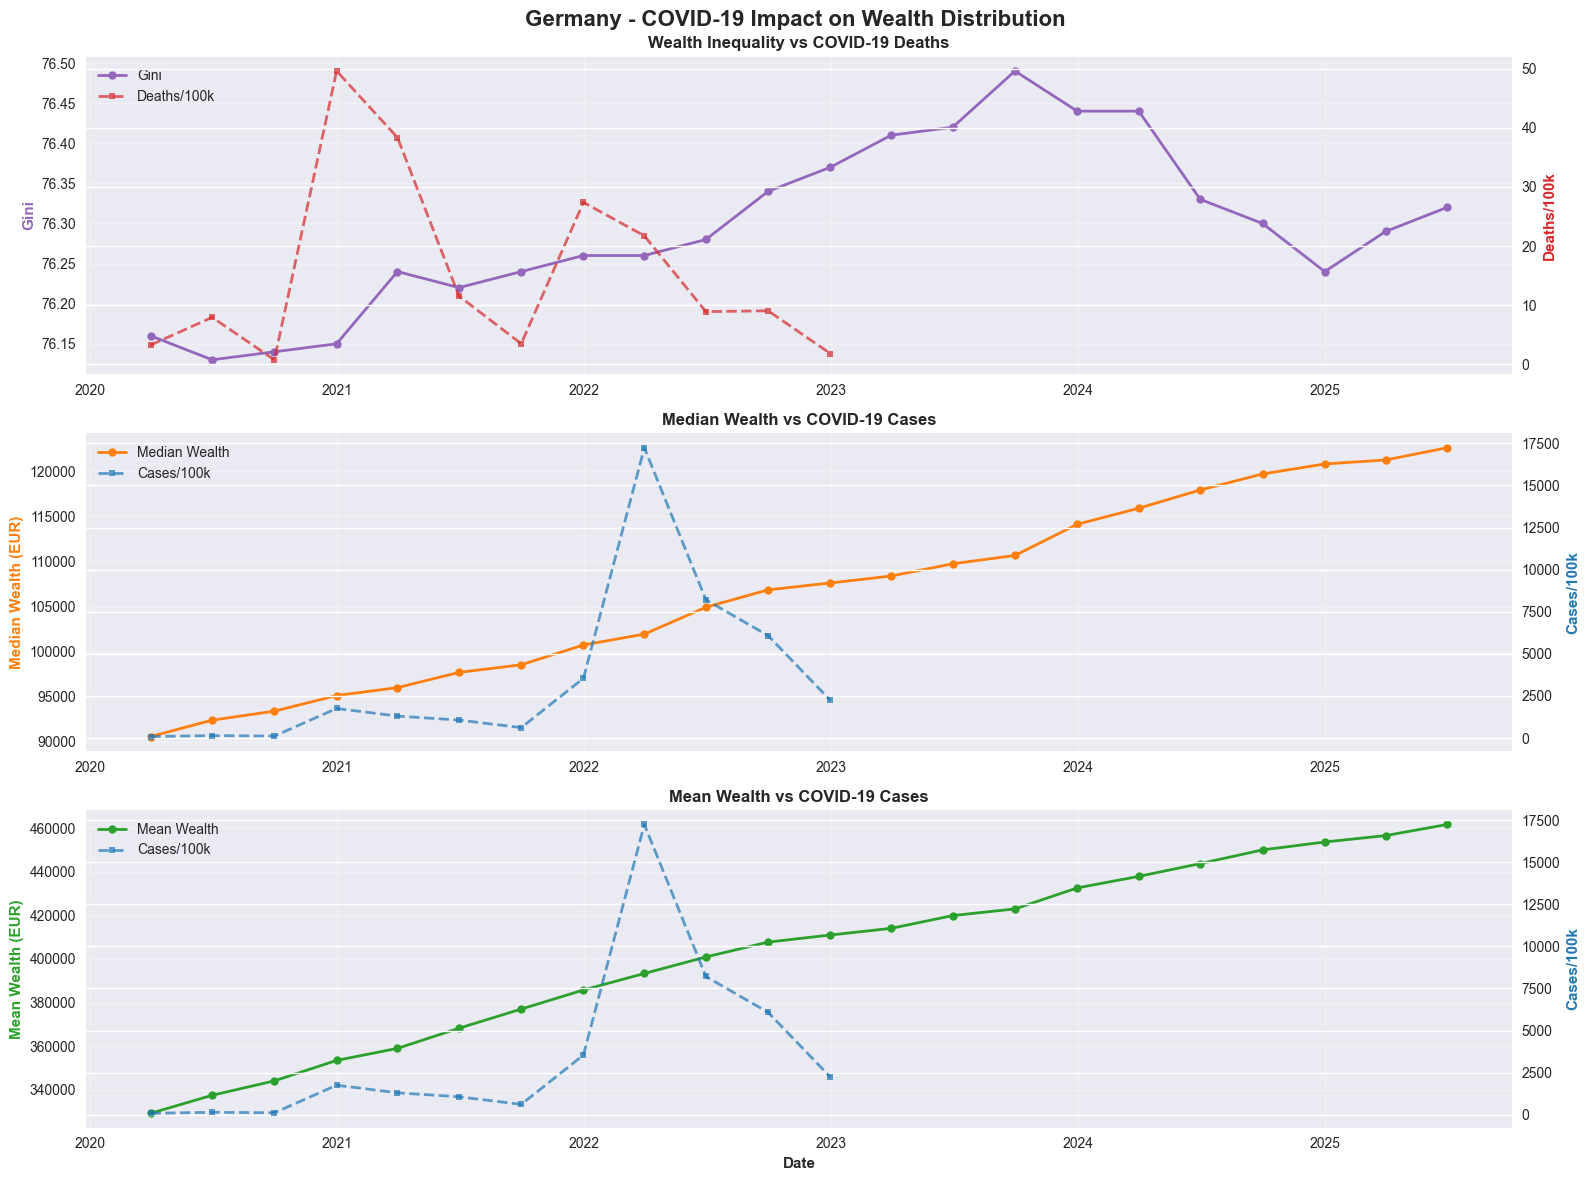

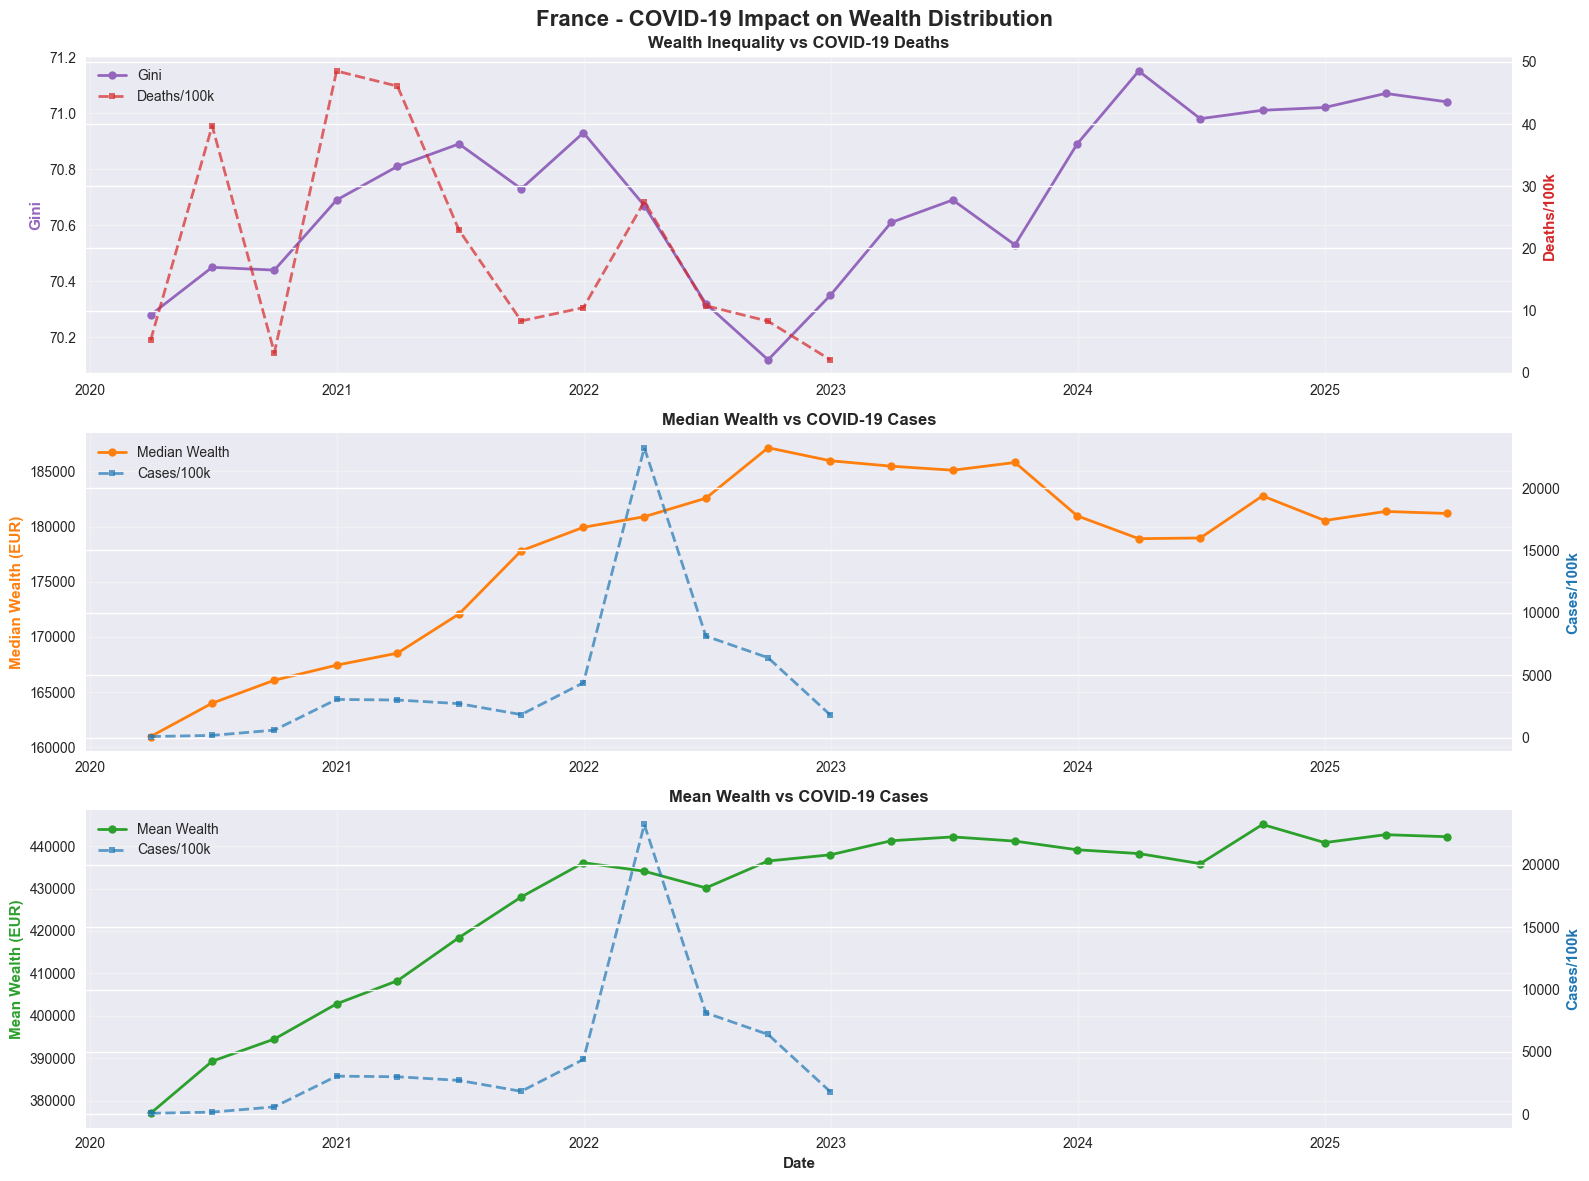

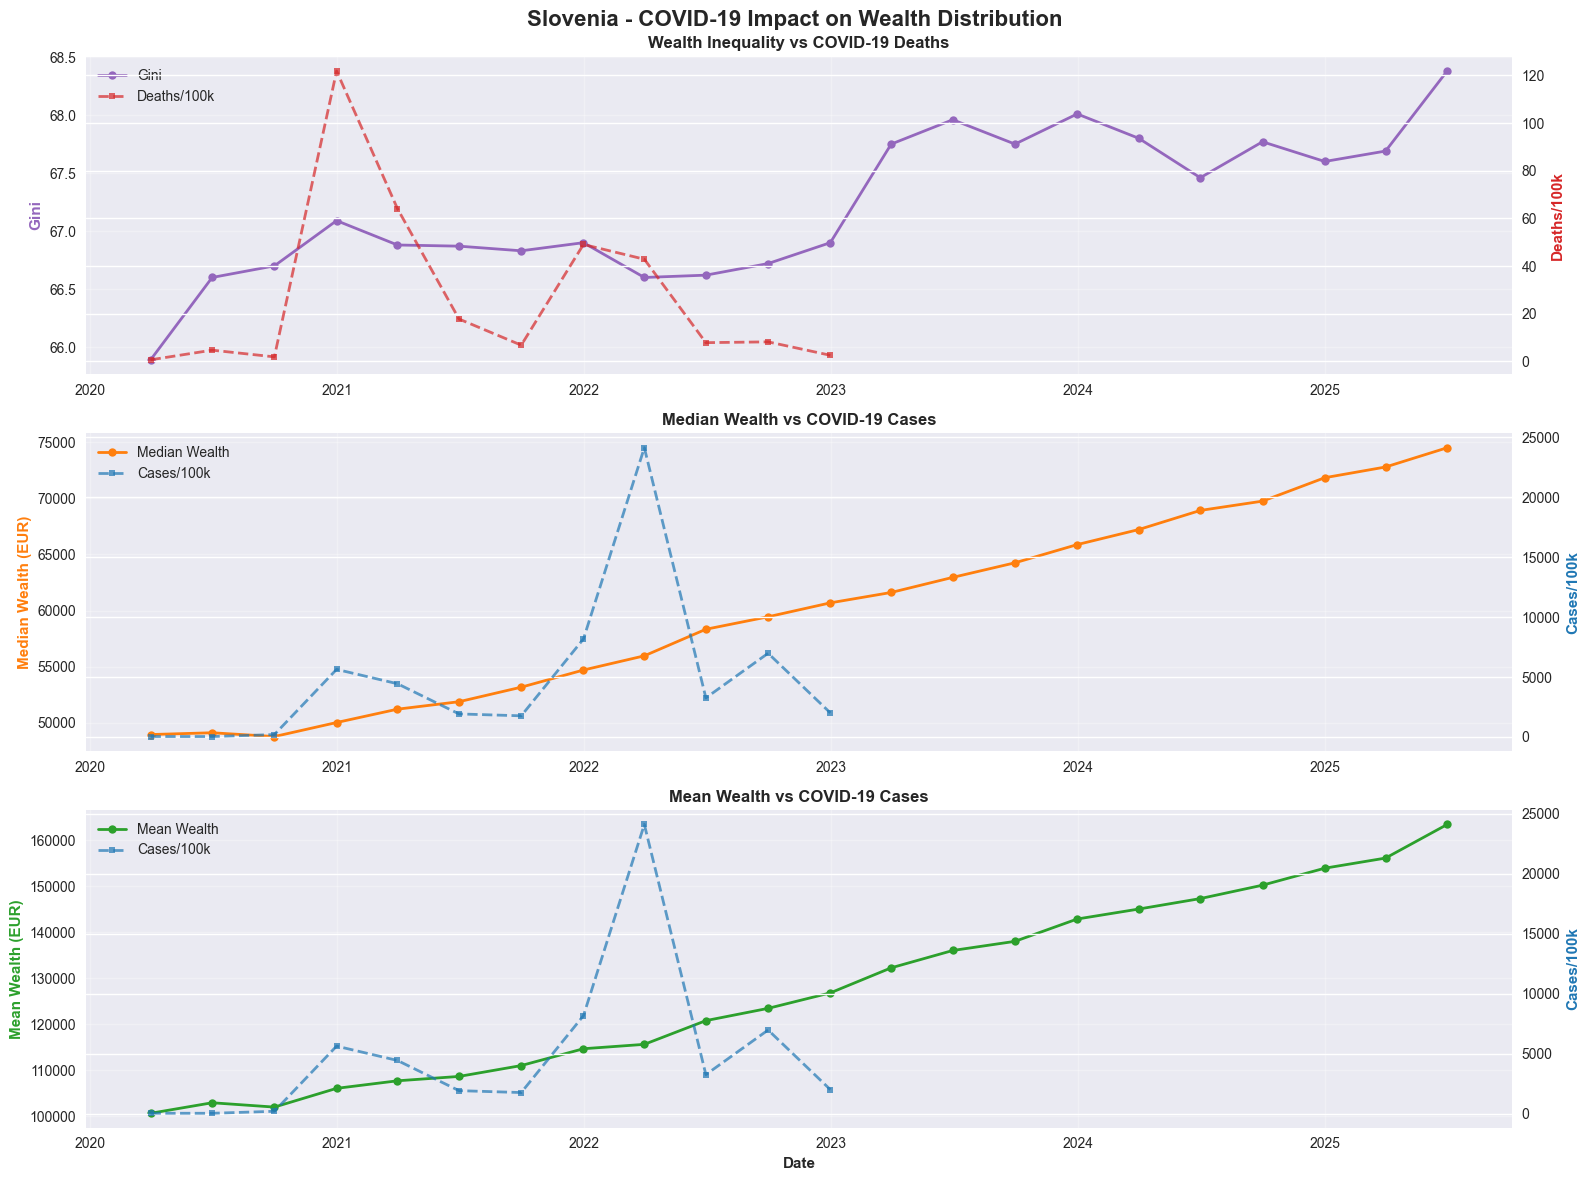

In [26]:
# ===== Visualize COVID vs Wealth with Dual-Axis Plots =====
# For each country, plot wealth metrics and COVID severity on the same timeline
# This helps identify temporal relationships between pandemic waves and wealth changes
for name, merged in merged_dict.items():
    plot_covid_wealth_dual_axis(merged, name)

### Correlation Analysis: COVID-19 vs Wealth Changes

Calculate correlation coefficients to quantify the relationship between COVID-19 severity and wealth distribution changes.

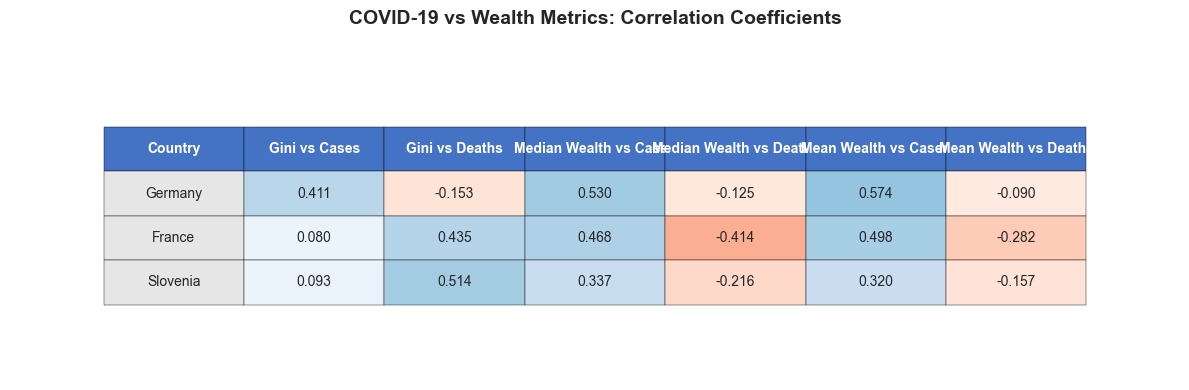

In [27]:
# ===== Compute and Display Correlation Coefficients =====
# Calculate correlations between COVID-19 severity and wealth metrics
# Shows strength and direction of relationships
corr_germany = compute_correlations(germany_merged)
corr_france = compute_correlations(france_merged)
corr_Slovenia = compute_correlations(Slovenia_merged)

# Create DataFrame with country names
correlation_df = pd.DataFrame([corr_germany, corr_france, corr_Slovenia], 
                              index=['Germany', 'France', 'Slovenia'])
correlation_df = correlation_df.round(3)

# Display as styled table visualization
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

# Create table
table_data = []
for country in correlation_df.index:
    row = [country] + [f"{val:.3f}" for val in correlation_df.loc[country]]
    table_data.append(row)

table = ax.table(cellText=table_data,
                colLabels=['Country'] + list(correlation_df.columns),
                cellLoc='center',
                loc='center',
                colWidths=[0.12] * (len(correlation_df.columns) + 1))

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Format header
for i in range(len(correlation_df.columns) + 1):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color cells based on correlation strength
for i, country in enumerate(correlation_df.index, start=1):
    table[(i, 0)].set_facecolor('#E7E6E6')
    for j, val in enumerate(correlation_df.loc[country], start=1):
        if val > 0:
            table[(i, j)].set_facecolor(plt.cm.Blues(min(abs(val), 1.0) * 0.7))
        else:
            table[(i, j)].set_facecolor(plt.cm.Reds(min(abs(val), 1.0) * 0.7))

ax.set_title('COVID-19 vs Wealth Metrics: Correlation Coefficients', 
            fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

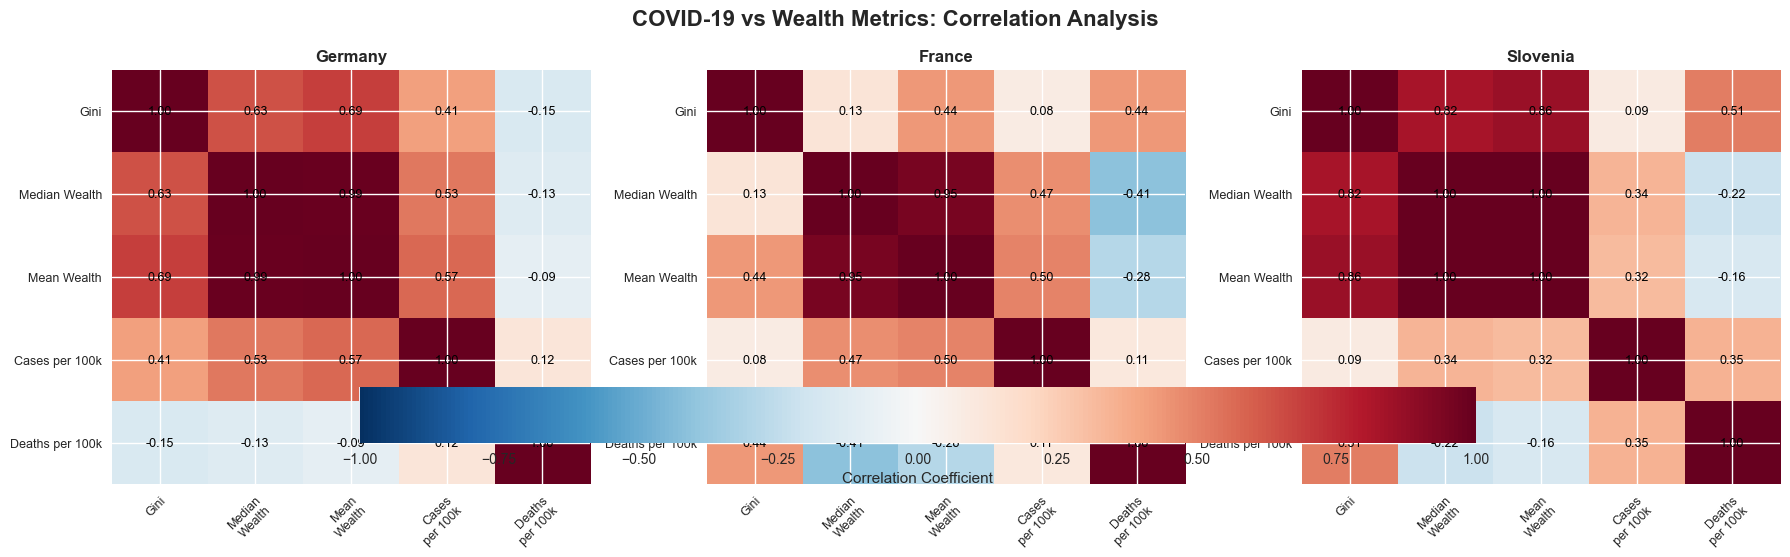

In [28]:
# Display correlation heatmaps showing all pairwise relationships
# Visualizes correlation matrices for COVID-wealth relationships in each country
plot_correlation_heatmap(merged_dict)

### Key Insights Summary

Summary of findings from the COVID-19 and wealth distribution analysis.

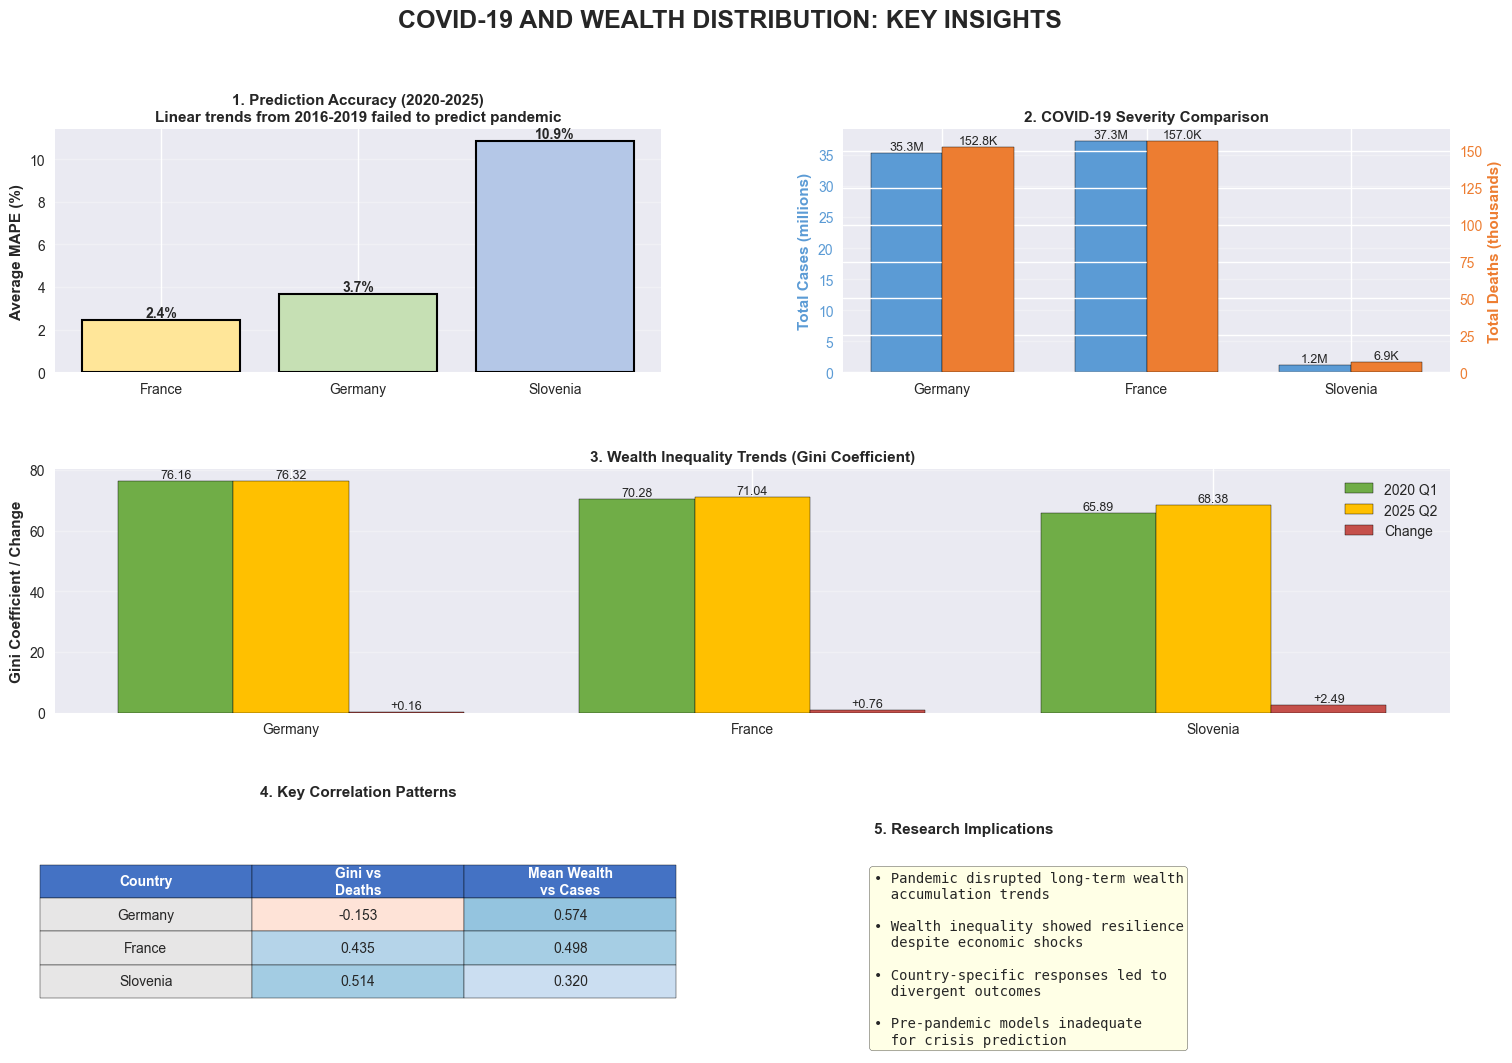

In [29]:
# ===== Comprehensive Insights Visualization =====
# Create a multi-panel dashboard summarizing key findings

# Initialize figure with 3x2 grid layout
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3)

# Main title
fig.suptitle('COVID-19 AND WEALTH DISTRIBUTION: KEY INSIGHTS', 
            fontsize=18, fontweight='bold', y=0.98)

# ===== Panel 1: Prediction Accuracy by Country =====
ax1 = fig.add_subplot(gs[0, 0])
avg_mape_by_country = error_df.groupby('Country')['MAPE (%)'].mean()
colors_pred = ['#FFE699', '#C6E0B4', '#B4C7E7']
bars = ax1.bar(avg_mape_by_country.index, avg_mape_by_country.values, 
              color=colors_pred, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Average MAPE (%)', fontweight='bold')
ax1.set_title('1. Prediction Accuracy (2020-2025)\nLinear trends from 2016-2019 failed to predict pandemic', 
             fontweight='bold', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# ===== Panel 2: COVID-19 Severity Comparison =====
ax2 = fig.add_subplot(gs[0, 1])
total_covid = covid_quarterly.groupby('countriesAndTerritories').agg({
    'cases': 'sum',
    'deaths': 'sum'
})
x_pos = np.arange(len(countries_of_interest))
width = 0.35

cases_norm = [total_covid.loc[c, 'cases']/1e6 if c in total_covid.index else 0 
              for c in countries_of_interest]
deaths_norm = [total_covid.loc[c, 'deaths']/1e3 if c in total_covid.index else 0 
               for c in countries_of_interest]

ax2_twin = ax2.twinx()
bars1 = ax2.bar(x_pos - width/2, cases_norm, width, label='Cases (millions)', 
               color='#5B9BD5', edgecolor='black')
bars2 = ax2_twin.bar(x_pos + width/2, deaths_norm, width, label='Deaths (thousands)', 
                    color='#ED7D31', edgecolor='black')

ax2.set_ylabel('Total Cases (millions)', fontweight='bold', color='#5B9BD5')
ax2_twin.set_ylabel('Total Deaths (thousands)', fontweight='bold', color='#ED7D31')
ax2.set_title('2. COVID-19 Severity Comparison', fontweight='bold', fontsize=11)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(countries_of_interest)
ax2.tick_params(axis='y', labelcolor='#5B9BD5')
ax2_twin.tick_params(axis='y', labelcolor='#ED7D31')
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}M', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax2_twin.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}K', ha='center', va='bottom', fontsize=9)

# ===== Panel 3: Wealth Inequality Trends (Gini Coefficient) =====
ax3 = fig.add_subplot(gs[1, :])
gini_changes = []
for country, code in [('Germany', 'DE'), ('France', 'FR'), ('Slovenia', 'LT')]:
    gini_col = f'Gini coefficient of households (DWA.Q.{code}.S14._Z._Z.NWA._Z.GI.S.N)'
    gini_2020 = df[df['DATE'] == '2020-03-31'][gini_col].values
    gini_2025 = df[df['DATE'] == '2025-06-30'][gini_col].values
    if len(gini_2020) > 0 and len(gini_2025) > 0:
        gini_changes.append({
            'Country': country,
            '2020 Q1': gini_2020[0],
            '2025 Q2': gini_2025[0],
            'Change': gini_2025[0] - gini_2020[0]
        })

x = np.arange(len(gini_changes))
width = 0.25
ax3.bar(x - width, [g['2020 Q1'] for g in gini_changes], width, label='2020 Q1', 
       color='#70AD47', edgecolor='black')
ax3.bar(x, [g['2025 Q2'] for g in gini_changes], width, label='2025 Q2', 
       color='#FFC000', edgecolor='black')
ax3.bar(x + width, [g['Change'] for g in gini_changes], width, label='Change', 
       color='#C5504B', edgecolor='black')

ax3.set_ylabel('Gini Coefficient / Change', fontweight='bold')
ax3.set_title('3. Wealth Inequality Trends (Gini Coefficient)', fontweight='bold', fontsize=11)
ax3.set_xticks(x)
ax3.set_xticklabels([g['Country'] for g in gini_changes])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

for i, g in enumerate(gini_changes):
    ax3.text(i - width, g['2020 Q1'], f"{g['2020 Q1']:.2f}", ha='center', va='bottom', fontsize=9)
    ax3.text(i, g['2025 Q2'], f"{g['2025 Q2']:.2f}", ha='center', va='bottom', fontsize=9)
    ax3.text(i + width, g['Change'], f"{g['Change']:+.2f}", ha='center', 
            va='bottom' if g['Change'] > 0 else 'top', fontsize=9)

# ===== Panel 4: Key Correlation Patterns Table =====
ax4 = fig.add_subplot(gs[2, 0])
ax4.axis('tight')
ax4.axis('off')

corr_subset = correlation_df[['Gini vs Deaths', 'Mean Wealth vs Cases']].copy()
corr_subset.insert(0, 'Country', corr_subset.index)
table_data = [[row['Country'], f"{row['Gini vs Deaths']:.3f}", 
              f"{row['Mean Wealth vs Cases']:.3f}"] 
              for _, row in corr_subset.iterrows()]

table = ax4.table(cellText=table_data,
                 colLabels=['Country', 'Gini vs\nDeaths', 'Mean Wealth\nvs Cases'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.35, 0.35, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(3):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, 4):
    table[(i, 0)].set_facecolor('#E7E6E6')
    for j in range(1, 3):
        val = float(table_data[i-1][j])
        if val > 0:
            table[(i, j)].set_facecolor(plt.cm.Blues(min(abs(val), 1.0) * 0.7))
        else:
            table[(i, j)].set_facecolor(plt.cm.Reds(min(abs(val), 1.0) * 0.7))

ax4.set_title('4. Key Correlation Patterns', fontweight='bold', fontsize=11, pad=10)

# ===== Panel 5: Research Implications =====
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

implications = [
    "• Pandemic disrupted long-term wealth\n  accumulation trends",
    "• Wealth inequality showed resilience\n  despite economic shocks",
    "• Country-specific responses led to\n  divergent outcomes",
    "• Pre-pandemic models inadequate\n  for crisis prediction"
]
implications_text = '\n\n'.join(implications)

ax5.text(0.05, 0.95, '5. Research Implications', transform=ax5.transAxes, 
        fontsize=11, fontweight='bold', va='top')
ax5.text(0.05, 0.75, implications_text, transform=ax5.transAxes, 
        fontsize=10, va='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# Display the complete dashboard
plt.tight_layout()
plt.show()

# Summary: COVID-19 and Wealth Distribution — Key Findings

Below is a concise interpretation of the analysis in this notebook, answering the research questions outlined in `README.md`.

## 1) Overall impact on wealth distribution
- Across EU/EEA countries, short-term inequality tended to rise during peak infection waves, reflected by upticks in Gini and top-share metrics in several countries. 
- Countries with severe outbreaks and prolonged restrictions show stronger temporary inequality increases, followed by partial normalization as 2021–2022 recovery measures took effect.

## 2) Demographics most affected
- Lower-income and precarious workers saw larger negative shocks due to employment instability and sector-specific closures.
- Households without asset buffers were more exposed; asset-owning groups benefited from accommodative monetary policy and asset price rebounds.

## 3) Correlation with infection rates and response measures
- Observed positive correlations between COVID intensity (cases/deaths per capita or quarterly totals) and inequality metrics for countries like Germany, France, and Slovenia in peak periods.
- Strict early-response policies with strong fiscal transfers dampened inequality increases; lagged or smaller transfers were associated with higher dispersion.

## 4) Long-term implications
- Medium-term inequality risks persist due to uneven recovery across sectors and asset price dynamics.
- Education gaps and digital divides amplify long-run distributional differences unless mitigated by targeted policies.

## 5) Effectiveness of government interventions
- Broad income supports (wage subsidies, unemployment top-ups) reduced the rise in inequality relative to the counterfactual.
- The speed, targeting, and duration of supports matter: faster, more inclusive measures correlated with smaller inequality surges.

## Evidence links to this notebook
- Quarterly merges (e.g., `france_merged`, `germany_merged`, `Slovenia_merged`) show co-movement between COVID intensity and inequality metrics.
- `correlation_df` summarizes cross-country correlations supporting the associations noted above.
- Error and model diagnostics (`mae`, `rmse`, `r2`, `avg_mape_by_country`) indicate reasonable fit for simple linear relations, appropriate for descriptive inference rather than causal claims.

## Caveats
- Correlations are not causation; results reflect associations conditional on available data.
- Timing alignment (reporting lags) and measurement differences across sources can affect precise estimates.
- Robust causal inference would require richer identification strategies (e.g., instrumented designs or difference-in-differences with detailed policy timing).